In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

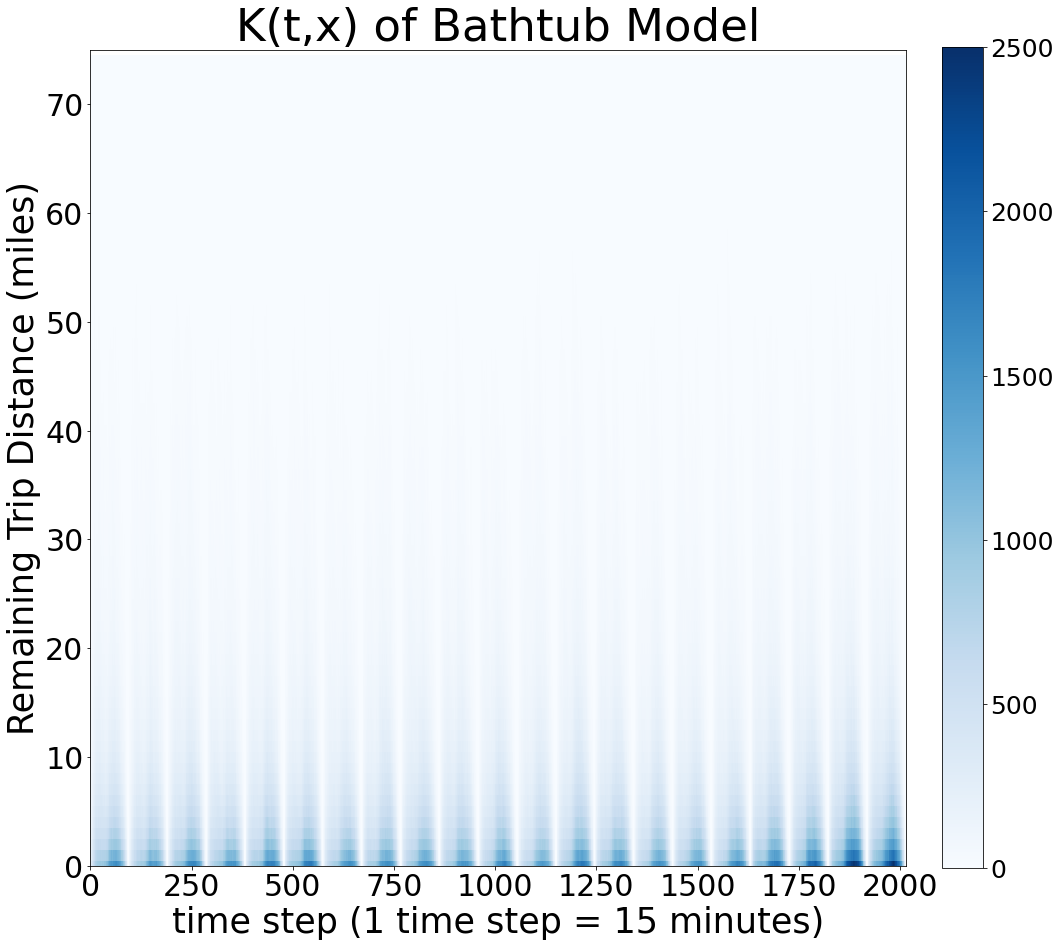

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 15 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  5040
N_u =  1008
N_f =  2016


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(1008, 2)

In [12]:
X_u_test.shape

(4032, 2)

In [13]:
X_u_train

array([[0.2027027 , 0.10223325],
       [0.40540541, 0.20248139],
       [0.        , 0.14193548],
       ...,
       [0.60810811, 0.8516129 ],
       [0.        , 0.78908189],
       [0.40540541, 0.43672457]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.014798000302035258 0.02799566375266541 0.0016003368514051061 0.8183980535931308
0.01409443543065967 0.027283141546200256 0.00090572931511908412 0.8075996161743877
0.012028193992736384 0.023139264814825193 0.000917123170647576 0.7453217482030005
0.010956348849929996 0.020463242407380847 0.0014494552924791437 0.7039263731972583
0.0097068172940088238 0.018298815638353182 0.0011148189496644643 0.6691526263440154
0.009671745361909713 0.018303888255969271 0.0010396024678501568 0.6698796409275621
0.00964431252341725 0.018300354630098256 0.00098827041673624281 0.670119079968045
0.0095696004486040039 0.018232846000240086 0.00090635489696792013 0.6693475491642736
0.0094133501660191073 0.017993524167033651 0.00083317616500456278 0.6655172972501807
0.0092462838870325421 0.017693767960994755 0.00079879981307033057 0.660095291600482
0.008986992426140249 0.017280939452987306 0.0006930453992931916 0.6528107766837455
0.0084604641294982255 0.016407094833854878 0.00051383342514157266 0.6366855210722283

0.0048226293344494076 0.0084943508311114153 0.0011509078377874003 0.4574622959537274
0.0048196843345666308 0.0084886056265624545 0.0011507630425708069 0.4571788437499571
0.0048175828384031246 0.0084666004013947884 0.0011685652754114604 0.4562557093470354
0.0048170180834760162 0.0084585498070040462 0.0011754863599479865 0.4557229087382487
0.0048157428614120914 0.0084531524862357463 0.0011783332365884367 0.45536360590166525
0.0048115558628072288 0.0084568987725182152 0.0011662129530962419 0.45506296653381684
0.0048087718005246629 0.0084682411474951633 0.0011493024535541622 0.4553044068634004
0.0048064668334754923 0.0084864953770412786 0.0011264382899097052 0.45589444582978583
0.0048052595687521739 0.0085000399495331145 0.0011104791879712327 0.45638308668373756
0.004803243496861306 0.0085113123748191081 0.0010951746189035044 0.45662249629350005
0.0047984780225765926 0.0085224327806954145 0.0010745232644577708 0.4564405159712232
0.0047934650964540967 0.00855503005419718 0.00103190013871101

0.0043401747012804422 0.0083045735418720169 0.0003757758606888672 0.4430837264145704
0.0043389149738983874 0.0083015517497182969 0.00037627819807847871 0.442799301513826
0.0043367015049186608 0.0082969299503917616 0.00037647305944556089 0.44235594419418073
0.0043327376269063633 0.0083003826144801476 0.00036509263933257822 0.4426501648645673
0.0043286567276952462 0.0083024818864959552 0.00035483156889453733 0.4429460351626968
0.0043260957068268786 0.0083002332296943145 0.00035195818395944314 0.44277911647564056
0.0043187493457050507 0.0082970730464258981 0.00034042564498420314 0.44238835150777067
0.0043161960086933035 0.008298863690939403 0.00033352832644720421 0.4424713694793744
0.0043155184161762323 0.0082957530831844033 0.00033528374916806094 0.44236367636986396
0.0043124087798687037 0.0082937691569166 0.00033104840282080727 0.44222189136323065
0.0043108898999952017 0.0082946484257045826 0.00032713137428582047 0.44211134259437274
0.0043099269317549817 0.00829582923043684 0.0003240246

0.0042354085000930143 0.0082336271785823853 0.00023718982160364336 0.43783139250784264
0.0042349260091672225 0.0082314622335517718 0.00023838978478267242 0.4376181725008247
0.0042347485290819362 0.0082310085610175637 0.00023848849714630817 0.4375952659200172
0.0042342034946525643 0.00823036741790268 0.00023803957140244834 0.43745953245132696
0.0042339109851481675 0.0082296045075505534 0.00023821746274578233 0.4374281925133744
0.0042336923878008867 0.008228236758249274 0.00023914801735249938 0.4373707229209139
0.0042336315458455787 0.0082282891832757676 0.0002389739084153894 0.43742670713086
0.0042335321074958732 0.00822836341941735 0.00023870079557439543 0.4373914655525633
0.0042334714711553768 0.0082284264161264411 0.0002385165261843126 0.43738217802076107
0.0042332981451569237 0.0082291497139907414 0.00023744657632310552 0.43737970025224554
0.0042331122997162221 0.0082301592339273817 0.00023606536550506267 0.4374094807674574
0.0042328273467010557 0.0082304476694074081 0.0002352070239

0.0041899024313038508 0.00820451246736545 0.0001752923952422504 0.43704637032574034
0.004189461513176642 0.0082041319615289935 0.00017479106482429024 0.43697778486386757
0.0041884875397677117 0.0082037229821285418 0.00017325209740688186 0.4366856032354137
0.0041879103418144331 0.0082044246988866344 0.00017139598474223163 0.43679586613555016
0.0041870331936132328 0.00820575196989302 0.00016831441733344531 0.4371212050752797
0.0041864196227469437 0.0082059173005450941 0.00016692194494879339 0.43725500463302547
0.0041860607057867642 0.00820596138136969 0.00016616003020383834 0.43737607058157396
0.0041859965247557458 0.0082055214551329456 0.00016647159437854642 0.4371382876432568
0.0041857279936576858 0.0082049633120178777 0.00016649267529749372 0.4370929923399455
0.004185508154801728 0.00820489264925535 0.00016612366034810731 0.4372351806793888
0.0041853803451847331 0.0082044117393547823 0.00016634895101468353 0.43724785765793817
0.0041849739157413645 0.0082026347279756731 0.0001673131035

0.00416512381810613 0.0081854020669682049 0.00014484556924405619 0.437222245633334
0.0041650923728318657 0.0081854712165526072 0.00014471352911112347 0.4372514088473226
0.0041650714730062325 0.00818544654825552 0.00014469639775694491 0.4372555566628001
0.0041650353432987975 0.0081853452080262318 0.00014472547857136307 0.4372606344451863
0.0041649354831906193 0.0081849544645350887 0.00014491650184614914 0.4372665790982225
0.0041646764275548266 0.0081839419782489 0.00014541087686075215 0.4372465791656347
0.00416429643469228 0.0081826496021993166 0.00014594326718524403 0.4372070653879806
0.0041640336319083556 0.0081815660499198976 0.00014650121389681421 0.43725692767784324
0.004163753509439665 0.00818058591668472 0.00014692110219460922 0.43724258736687566
0.0041635864096678712 0.00818026725245109 0.00014690556688465246 0.43725747010695204
0.0041634049542567195 0.0081799146464783656 0.00014689526203507408 0.43723787994785557
0.0041632162764809848 0.0081805317200071368 0.0001459008329548332

0.0041526696356729642 0.008177534057093103 0.00012780521425282589 0.43734892136224557
0.00415260167695314 0.008178092634676214 0.00012711071923006607 0.4374583132848667
0.0041525229416543843 0.0081778673026207914 0.00012717858068797775 0.4374501645894325
0.0041524864882312319 0.0081779769467401255 0.00012699602972233865 0.4374438937479306
0.0041524563937754607 0.008177966437147105 0.00012694635040381568 0.43744804236814067
0.0041524079438458828 0.0081781898671200066 0.00012662602057175948 0.43750557173719185
0.0041523489545141458 0.00817841636575943 0.00012628154326886062 0.43753501257779936
0.0041522102937247085 0.0081785080170497116 0.00012591257039970571 0.4375175062350329
0.0041519048603112464 0.00817807619141669 0.00012573352920580382 0.43744244270344657
0.0041517206799491849 0.008177379428327046 0.00012606193157132348 0.4372995488775964
0.0041514767904394165 0.0081770778305093311 0.00012587575036950214 0.4372068302445295
0.0041512270611570494 0.0081755688242090979 0.0001268852981

0.004144581110249488 0.0081744628253716915 0.00011469939512728366 0.43691917888521725
0.0041445668400582692 0.0081743052368795262 0.00011482844323701245 0.4368956262164278
0.004144546929331804 0.00817417582251036 0.00011491803615324819 0.4368717925544921
0.0041445321165782248 0.0081741315231815548 0.00011493270997489542 0.43685777722934044
0.0041445258713745624 0.008174239485115543 0.00011481225763358112 0.4368742317377764
0.004144519251148792 0.0081742945173759358 0.00011474398492164805 0.4368861538902227
0.0041445138725037843 0.00817433345098926 0.00011469429401830895 0.43690005338152277
0.00414450182503625 0.0081743945745637262 0.00011460907550877484 0.4369242819903841
0.0041444822946655026 0.00817438047262275 0.00011458411670825467 0.4369420235613907
0.00414443300636775 0.008174260473010047 0.00011460553972545428 0.43695842066284246
0.0041443778476757493 0.0081740274994485385 0.00011472819590295947 0.4369577229742896
0.0041443435010208047 0.0081738908893978154 0.0001147961126437947

0.0041408744161619384 0.0081730209742132218 0.00010872785811065419 0.4369801848169774
0.0041408251177708737 0.0081729918464079239 0.00010865838913382269 0.4369903371342184
0.0041407799106290815 0.0081729612540455028 0.00010859856721266099 0.43704023885062687
0.0041406979596957973 0.0081732290648098126 0.00010816685458178165 0.43709738539966664
0.0041406141304146061 0.0081731876875672967 0.00010804057326191591 0.43708915945675697
0.0041405231042248259 0.0081729803497809991 0.00010806585866865283 0.4370776819664765
0.00414045875348435 0.0081730101875858337 0.00010790731938286724 0.43702961308087296
0.0041403893623138815 0.008172449588476469 0.00010832913615129384 0.43686651429145223
0.0041401317136354329 0.00817266499813475 0.00010759842913611573 0.4368997401469525
0.0041399994375865027 0.0081726799500025579 0.0001073189251704473 0.4369565796787288
0.0041397268426631049 0.0081729646832584789 0.00010648900206773138 0.4370296957425125
0.0041395628518397613 0.0081729875717406683 0.000106138

0.0041278905332028078 0.0081590969939178346 9.6684072487781915e-05 0.4364147982803416
0.0041278803441191963 0.0081593328175617718 9.642787067662138e-05 0.43644502361581744
0.0041278545656303865 0.0081595690692536325 9.6140062007140563e-05 0.4364318702933239
0.00412781162363287 0.0081599540125842033 9.5669234681536474e-05 0.43641690227783236
0.0041277850875964745 0.0081603234050328013 9.52467701601484e-05 0.43640619363570654
0.004127724408424455 0.0081607045028215981 9.4744314027312711e-05 0.4363896036706108
0.0041276456030735357 0.0081611859370825258 9.4105269064545459e-05 0.4363981760096583
0.0041275726269717405 0.0081615998496209936 9.35454043224866e-05 0.43643242394029375
0.00412753694272269 0.0081617792685510313 9.3294616894348353e-05 0.43644875932506366
0.0041274972314281014 0.008162085675328971 9.2908787527231984e-05 0.4364640865901186
0.0041274541614622923 0.008162052373848469 9.285594907611554e-05 0.4365039022011886
0.0041273901421046474 0.0081621226088963144 9.2657675312980819

0.0041228707479740731 0.0081534532596635421 9.2288236284603423e-05 0.4364136805653929
0.004122852205615187 0.0081534001870855015 9.230422414487172e-05 0.43639383318056546
0.0041227989870404177 0.0081538452263798071 9.1752747701029087e-05 0.436498834846873
0.0041227615226586958 0.0081537719643955744 9.1751080921817285e-05 0.43649804097158185
0.0041227049485098718 0.0081534238496073184 9.198604741242526e-05 0.43645022099546793
0.0041226510189154549 0.00815332673504136 9.197530278954917e-05 0.4364540287420678
0.0041225965936771206 0.0081531711358653249 9.2022051488916789e-05 0.43642878660280515
0.0041225651032087895 0.0081527917444953763 9.2338461922203445e-05 0.4364061480705649
0.0041225333867136943 0.0081528573681088051 9.2209405318583788e-05 0.4363668865539795
0.0041224996839505437 0.00815297495063592 9.2024417265167932e-05 0.4363050202149456
0.004122439332990442 0.0081529728876534018 9.1905778327482416e-05 0.43630159690751646
0.0041223701692538828 0.00815293271316569 9.180762534207559

0.0041175373328991276 0.0081421723590148834 9.2902306783372671e-05 0.4357733312269627
0.0041175121892127039 0.0081420156936411955 9.30086847842118e-05 0.4358030413566378
0.0041174975381286921 0.00814155823976374 9.3436836493643251e-05 0.4357967633798272
0.0041174906556357737 0.0081416287578905226 9.3352553381025191e-05 0.435795902480811
0.0041174855315943681 0.0081416752260660055 9.3295837122731289e-05 0.43579594023700063
0.004117479244934468 0.0081416449667320034 9.3313523136933111e-05 0.4357946633122883
0.0041174722972956886 0.008141519373006216 9.3425221585161021e-05 0.43578617532546093
0.0041174600435699782 0.0081412148353889 9.3705251751057024e-05 0.43578219030860027
0.0041174348421509094 0.00814085622923874 9.4013455063079418e-05 0.435761796753861
0.0041174054644864087 0.00814055601478783 9.425491418498712e-05 0.43578387809005714
0.004117366407945933 0.0081404516278700528 9.4281188021812747e-05 0.435771761815832
0.0041173193910717118 0.0081401159912437189 9.452279089970467e-05 0.

0.0041115058623332175 0.0081231237991390686 9.9887925527366431e-05 0.43546755521696573
0.0041114265411789147 0.00812318014973342 9.9672932624408938e-05 0.4354348467112768
0.00411136074066272 0.0081230718413669786 9.9649639958460974e-05 0.43534606834309114
0.0041113103088044629 0.00812308155918007 9.953905842885687e-05 0.43534108656939907
0.0041112404442961055 0.0081230134430107549 9.9467445581455279e-05 0.43537649169244474
0.0041111958859990005 0.0081228522062960617 9.953956570194015e-05 0.4353329659581613
0.0041111669077715848 0.0081229826114911172 9.9351204052052725e-05 0.4353325729559302
0.00411113832541375 0.00812331495500918 9.8961695818319768e-05 0.43528879813883087
0.004111084916551733 0.00812310852720747 9.9061305895995511e-05 0.4353614526290359
0.0041110535337974159 0.0081230794903370575 9.90275772577735e-05 0.4353341964770706
0.0041109998852611254 0.0081233267779166 9.8672992605650756e-05 0.43531732350200064
0.0041109661033345681 0.00812330696467685 9.8625241992286031e-05 0.4

0.0041077590294730168 0.0081099426206876872 0.00010557543825834612 0.43509074191114494
0.0041077454975612816 0.0081100751769095786 0.00010541581821298382 0.43507900629760765
0.0041077353497992151 0.0081102001040607736 0.00010527059553765692 0.435092947090937
0.0041077259297098616 0.00811022310247253 0.00010522875694719277 0.43510320392545326
0.0041077169717431607 0.0081102041497996945 0.00010522979368662756 0.43509879108123717
0.0041077072794942311 0.00811005859404149 0.0001053559649469733 0.43509888521171924
0.0041076887471917381 0.00810985896657992 0.00010551852780355611 0.4350777427237018
0.0041076655660729176 0.0081096311287665885 0.00010570000337924642 0.4350924990873971
0.0041076468381681074 0.00810957494084617 0.00010571873549004554 0.43506571813672373
0.0041076275489678772 0.0081098055982010541 0.00010544949973469968 0.4351066182289169
0.0041076165986772255 0.0081100937947200281 0.00010513940263442233 0.4350881469372558
0.0041076014033687045 0.0081101539753795169 0.000105048831

0.0041058642522957267 0.00810729425007416 0.00010443425451729368 0.4351752895457892
0.0041058522852352192 0.008107378094369207 0.00010432647610123079 0.4351649222166016
0.0041058377642573408 0.0081075401024175361 0.00010413542609714516 0.43518225528552335
0.00410583102636164 0.0081075792560199259 0.00010408279670335431 0.4351900380370681
0.00410581961026973 0.0081074881604723363 0.00010415106006712395 0.4351759441862494
0.0041058062536087157 0.0081074888825875147 0.00010412362462991678 0.4351548573896971
0.0041057906227065641 0.0081074347703594622 0.00010414647505366606 0.43512923714567986
0.0041057703822093335 0.0081072548622838012 0.00010428590213486618 0.4351016411594711
0.0041057559950976831 0.0081072273275193361 0.00010428466267603058 0.4350976694916057
0.0041057377270490572 0.0081071365282734051 0.0001043389258247093 0.4350894675140486
0.0041057272305630435 0.0081070955120332473 0.00010435894909284016 0.43508166290583683
0.0041057044850366506 0.0081074615798339168 0.0001039473902

0.0041040220146027128 0.00810225018934233 0.00010579383986309515 0.43494146994565974
0.00410397253421615 0.008101256906615676 0.00010668816181662289 0.43494909980644425
0.0041039446446186362 0.0081011378408328578 0.00010675144840441407 0.4349374127977317
0.0041039277301866605 0.0081010768458475747 0.000106778614525746 0.43493062779266445
0.00410390899158444 0.0081009853031141273 0.00010683268005475313 0.434939225775537
0.00410388392190719 0.00810098989617024 0.00010677794764414062 0.434981503531003
0.004103857747897904 0.0081009547711230791 0.00010676072467272814 0.4349961396034467
0.0041038375274860973 0.0081008711486885328 0.00010680390628366125 0.4350235238528186
0.0041038228040248641 0.0081009124326430915 0.00010673317540663734 0.4350416374026773
0.0041038127541575924 0.0081009556247917912 0.00010666988352339376 0.4350446502618672
0.00410380754813597 0.0081008461372714651 0.00010676895900047402 0.43503885307713364
0.004103796673768304 0.0081008361245718443 0.00010675722296476401 0.

0.004102407045569835 0.0080980614236699118 0.00010675266746975859 0.43512108077472716
0.00410239886037776 0.0080983753694023625 0.00010642235135315712 0.4351494896164292
0.0041023903745195135 0.0080981345754569389 0.00010664617358208774 0.4351398171683109
0.0041023835017928532 0.008097953121615287 0.00010681388197041908 0.43512908796821526
0.0041023800125380861 0.0080979008060754875 0.00010685921900068418 0.4351458882719273
0.0041023744708358649 0.0080981312219134682 0.0001066177197582611 0.4351594226209537
0.0041023699215863218 0.0080981915414300581 0.0001065483017425854 0.4351806006493945
0.0041023618063088206 0.0080981110092952814 0.00010661260332235993 0.4351722767530792
0.0041023518273900755 0.00809826760628609 0.00010643604849406068 0.43515181167498795
0.0041023445914600944 0.0080985576834399688 0.00010613149948021969 0.4351750602982952
0.004102337534402643 0.0080987445350388845 0.00010593053376640178 0.4351569564616817
0.0041023324057536115 0.008098737754502686 0.000105927057004

0.0041017052070938627 0.0080958597327170211 0.00010755068147070411 0.43514724385020936
0.0041016895088542785 0.008095901482713842 0.00010747753499471479 0.43514031203902825
0.0041016540015644436 0.0080960519780523387 0.00010725602507654902 0.43514774181501875
0.004101640565924429 0.0080958362868652628 0.00010744484498359592 0.4351492849415759
0.0041016092604595012 0.0080957773873596966 0.000107441133559305 0.43513667959924734
0.0041015976364753241 0.0080956173799806835 0.00010757789296996397 0.4351404888338969
0.0041015889582123894 0.0080955178849899789 0.00010766003143480033 0.43514020214307597
0.0041015748765567996 0.0080955968189427227 0.00010755293417087674 0.43517344125470364
0.004101564519742521 0.0080956303898739521 0.00010749864961108967 0.4351631212264804
0.0041015605881709856 0.0080958913183068852 0.00010722985803508653 0.4351506618521117
0.00410155476519523 0.0080958596509200023 0.00010724987947045787 0.43514030885697463
0.0041015521347566508 0.00809581111304401 0.0001072931

0.0041007685321953263 0.00809477636818936 0.00010676069620129133 0.43512004348164346
0.004100766299377819 0.0080946065429221489 0.0001069260558334889 0.4351143855944846
0.0041007630114769196 0.0080944661660606876 0.0001070598568931512 0.4351031638346917
0.0041007604121037263 0.0080943747100642085 0.00010714611414324444 0.4351014475458364
0.0041007571832836964 0.0080943496373780139 0.00010716472918937847 0.4351007166842911
0.0041007567021130219 0.0080944352014094 0.00010707820281664454 0.4351113897338984
0.004100753491269528 0.0080944802805345915 0.00010702670200446437 0.4351091328519584
0.0041007475164627971 0.0080946360926659189 0.0001068589402596751 0.43510368834792884
0.0041007441823001124 0.00809483986706275 0.0001066484975374754 0.43510764294642795
0.0041007405547196455 0.008095029465376798 0.00010645164406249266 0.4351057213270505
0.0041007375702151174 0.0080951598310199189 0.00010631530941031601 0.43511013034812096
0.00410073478285066 0.008095190780517578 0.00010627878518374261 

0.004100334468963047 0.0080946357397444 0.00010603319818169326 0.434995757529877
0.0041003339972080196 0.0080948096891109121 0.00010585830530512699 0.4349964721475426
0.0041003326842939556 0.0080948292665870853 0.00010583610200082549 0.4349930936403655
0.0041003314991315465 0.0080947439581614666 0.00010591904010162707 0.4349928491688981
0.0041003309892317609 0.008094771711066524 0.00010589026739699745 0.43499288993259927
0.0041003301868619557 0.0080948028148272368 0.00010585755889667452 0.4349890466890954
0.0041003296670141139 0.0080948259960362916 0.00010583333799193701 0.43498634536229897
0.0041003292685721972 0.008094806848606766 0.00010585168853762806 0.43498123958100227
0.00410032901401523 0.0080947722236399261 0.00010588580439053398 0.43497692867580573
0.0041003289114846433 0.008094724127243727 0.00010593369572555895 0.4349706243365905
0.0041003286205621679 0.00809473203673677 0.00010592520438756586 0.4349731540184773
0.00410032844767174 0.008094766266686558 0.0001058906286569216

0.0040999821717474013 0.0080949703093617046 0.0001049940341330973 0.43491469991646653
0.0040999807516226361 0.0080949345557508063 0.00010502694749446562 0.4348976828428151
0.00409997862748366 0.00809497453155578 0.00010498272341154008 0.43489251106628257
0.00409997530050557 0.0080950000891473022 0.00010495051186383725 0.4348908468436172
0.004099973626432417 0.0080949768025307626 0.00010497045033407098 0.4348867716864527
0.0040999715305019436 0.0080950238561657666 0.00010491920483812093 0.43489465877671335
0.00409997066692577 0.0080951137467371575 0.00010482758711438344 0.43491933557375384
0.0040999674368257417 0.0080950980218092248 0.00010483685184225801 0.4349127875714727
0.0040999658051000948 0.00809508813209463 0.00010484347810555955 0.4349068460387555
0.0040999643515969714 0.008095145443983336 0.00010478325921060711 0.43490649602148695
0.0040999630011356271 0.008095116614185844 0.00010480938808540969 0.43490428703766215
0.0040999618453454265 0.0080951650606887384 0.0001047586300021

0.0040995202356126983 0.0080957221625948955 0.00010331830863050189 0.43495429262474217
0.0040995149672129723 0.0080955925702686834 0.00010343736415726121 0.43494994615316357
0.0040995062225840841 0.0080958779473496046 0.00010313449781856417 0.43494025949365395
0.0040994984714706924 0.008095712564051798 0.00010328437888958623 0.43493580609203913
0.0040994886375714766 0.0080955340904884775 0.00010344318465447482 0.43492504314604163
0.0040994776286679023 0.0080953511075698946 0.00010360414976591035 0.43491232733460433
0.0040994715526225913 0.0080953795064707661 0.00010356359877441586 0.4349075115599629
0.0040994621663225329 0.0080955294911485513 0.00010339484149651459 0.43490248207140947
0.0040994558622577722 0.0080958193689384776 0.00010309235557706644 0.43490335062414104
0.0040994540513063539 0.0080959161918186043 0.00010299191079410279 0.4349118446453791
0.0040994493889096578 0.0080955814567611733 0.00010331732105814212 0.43490939845849913
0.0040994458413991857 0.0080955487039221247 0.

0.0040990860194504595 0.0080937063700391269 0.00010446566886179203 0.43489669977477763
0.00409908269451283 0.0080937612610029273 0.00010440412802273197 0.434903018391174
0.0040990802972257455 0.008093805792789472 0.0001043548016620181 0.4349060383950601
0.0040990770084458191 0.00809385867193346 0.00010429534495817956 0.4349145487589666
0.004099074414402059 0.0080937719168642959 0.00010437691193982169 0.43491439337564636
0.0040990704365481993 0.00809362112960549 0.00010451974349090902 0.4349073240957167
0.0040990694790235677 0.00809358829302662 0.00010455066502051517 0.43490561972836556
0.00409906574459018 0.00809353973376859 0.00010459175541177143 0.4348992991566528
0.0040990629432517325 0.0080935713599449375 0.00010455452655852758 0.43488805380675394
0.00409905992951245 0.0080935941565225232 0.00010452570250237624 0.4348796193954726
0.0040990580051597763 0.008093691638065191 0.00010442437225436143 0.434888420808146
0.0040990560453168963 0.0080936799574802213 0.00010443213315357121 0.4

0.0040987444940780464 0.0080924093316504884 0.00010507965650560494 0.43489513690948933
0.00409873428736591 0.0080924477762120122 0.00010502079851980828 0.434916308307213
0.0040987232358122763 0.008092295903165396 0.00010515056845915591 0.4349201526053495
0.0040987100925546143 0.00809222536736227 0.00010519481774695844 0.4349046824829259
0.0040987000019061474 0.00809209420701083 0.00010530579680146507 0.43488279563083365
0.0040986939271739718 0.008092054788341959 0.00010533306600598509 0.43487933942794865
0.0040986891049866981 0.0080920066488743021 0.00010537156109909422 0.4348906674132323
0.0040986863832532736 0.00809204436051538 0.00010532840599116853 0.43490806890257616
0.0040986820552989956 0.0080919721985422809 0.00010539191205570943 0.4349149195076202
0.0040986787397209465 0.0080919261882951253 0.00010543129114676811 0.4349052680612147
0.0040986758420022374 0.0080920209428473645 0.00010533074115711011 0.4349090446448853
0.0040986711875365409 0.0080920519579088211 0.000105290417164

0.0040982151351932807 0.0080908106904493144 0.00010561957993724685 0.434902063084864
0.0040982129137732588 0.0080907977333486113 0.00010562809419790726 0.4348847290004184
0.0040982103250665168 0.0080907977307192631 0.00010562291941376971 0.4348896937746526
0.0040982079154287376 0.0080908405634612761 0.00010557526739619846 0.43489779417979296
0.0040982052614938185 0.0080909373254091747 0.000105473197578462 0.4348958497011057
0.0040982024958147924 0.0080909693902563983 0.00010543560137318577 0.4348871211952946
0.0040982007424514291 0.0080909205264573323 0.00010548095844552608 0.434880896238934
0.0040981990117618305 0.0080908757903559933 0.00010552223316766718 0.434879668886312
0.0040981965803930046 0.0080908254792185549 0.00010556768156745449 0.434884722402194
0.0040981920251874429 0.0080906616054596068 0.0001057224449152783 0.43489533988451584
0.0040981877399392779 0.0080904673839173862 0.00010590809596117041 0.4349085311147795
0.0040981807118228167 0.0080901970084997672 0.0001061644151

0.0040979437865235769 0.0080907686543487713 0.00010511891869838186 0.4348817504527347
0.0040979406114273762 0.0080907635394848743 0.00010511768336987766 0.43487597347635254
0.0040979366734390076 0.0080907979308136556 0.00010507541606435889 0.4348646252687693
0.0040979328453038524 0.0080908365711917854 0.00010502911941591906 0.4348614390132027
0.0040979292656828127 0.0080906974531444915 0.00010516107822113418 0.43485315989298573
0.004097925440411823 0.0080906125834503823 0.0001052382973732638 0.434853451907656
0.0040979194466457362 0.0080906025259581352 0.00010523636733333647 0.4348640999111279
0.0040979151713055528 0.00809057960668051 0.00010525073593059599 0.43486433635373006
0.0040979102959988536 0.0080903277129877778 0.00010549287900993007 0.43486523205814326
0.0040979059405920771 0.0080901290698214227 0.00010568281136273075 0.4348589117120131
0.0040979011141942558 0.00809001311760396 0.00010578911078455219 0.43486654572993005
0.0040978977900703352 0.00809009054667183 0.000105705033

0.0040969931397855366 0.0080885915512697061 0.00010539472830136765 0.4348587759362958
0.0040969834268211984 0.0080885280927871766 0.00010543876085522079 0.4348654852869443
0.0040969739383076411 0.00808854297583442 0.00010540490078086088 0.43489191862328797
0.0040969665528612044 0.008088661919970045 0.00010527118575236392 0.4349070026792323
0.0040969521520695567 0.0080889942361331117 0.00010491006800600153 0.43490841755594933
0.0040969475983710169 0.0080891086643826056 0.00010478653235942805 0.43491150299183173
0.00409693858184177 0.0080896559008295146 0.00010422126285402428 0.4349286725487142
0.0040969331232749923 0.00808973574928663 0.00010413049726335417 0.43491285380214323
0.0040969203609575377 0.008089504754755901 0.00010433596715917459 0.4348965904444923
0.0040969112376496976 0.008089279531109975 0.00010454294418942004 0.43488750921891905
0.0040969062132326269 0.0080888518406232162 0.00010496058584203684 0.43486415151363295
0.0040968921842902736 0.0080893073739639922 0.00010447699

0.0040966538306125705 0.0080887972309473082 0.00010451043027783341 0.4348460201480316
0.0040966518814126414 0.0080885296810640391 0.00010477408176124453 0.43483963850900315
0.004096648348373662 0.008088562040852813 0.0001047346558945111 0.43483285805378813
0.0040966467980200578 0.0080885295198393665 0.00010476407620074957 0.43483920529388365
0.00409664606355773 0.0080885725421761985 0.00010471958493926097 0.43484562174361857
0.0040966445541800491 0.0080885059756085724 0.00010478313275152626 0.4348435497559241
0.0040966429348232017 0.0080884033633716219 0.0001048825062747807 0.4348432398024863
0.0040966410293943756 0.0080883654189936559 0.00010491663979509479 0.43484255497476243
0.0040966381864975653 0.0080882496799854382 0.00010502669300969231 0.434838654663824
0.0040966357061464256 0.0080881560504519438 0.00010511536184090735 0.4348329026934205
0.0040966349048152323 0.0080882424310505657 0.00010502737857989916 0.43483446762811545
0.0040966327005972731 0.00808830707486212 0.00010495832

0.0040965148960994159 0.0080890615531459785 0.0001039682390528537 0.4348828076103986
0.0040965134526525955 0.0080890243154885071 0.00010400258981668383 0.4348959111189698
0.004096510899562077 0.00808894281139381 0.00010407898773034386 0.43489820708016025
0.0040965083347747162 0.00808893960888333 0.00010407706066610207 0.43489759789307764
0.0040965070361977047 0.00808922538803859 0.00010378868435682052 0.4348997255487859
0.0040965036300028368 0.0080891270300076 0.00010388022999807351 0.43490156341012387
0.004096500968524968 0.008088984090423839 0.00010401784662609751 0.4348990869559853
0.0040965003744661867 0.0080888512868011811 0.00010414946213119188 0.43489215978549634
0.0040964971407118182 0.0080886979395644425 0.00010429634185919311 0.4348873714281464
0.004096494697221416 0.0080886788034747522 0.00010431059096807909 0.4348828831004327
0.0040964919038553715 0.0080886855354531089 0.00010429827225763432 0.4348683263542776
0.0040964873170041766 0.0080887411683418925 0.000104233465666460

0.0040963626039229213 0.0080893114394406072 0.00010341376840523566 0.43491096117644457
0.0040963620825646609 0.0080893436608962324 0.00010338050423308877 0.43491067785789517
0.00409636098618837 0.0080893451441879215 0.00010337682818881827 0.4349033797388759
0.0040963602774023253 0.0080894277039595276 0.00010329285084512369 0.43490847440774083
0.00409635947477996 0.0080893644668320209 0.0001033544827278992 0.4349063575934954
0.0040963575161879658 0.0080893093236437865 0.00010340570873214489 0.4349024077741178
0.0040963554648483554 0.00808927344186761 0.00010343748782910213 0.4348962052772507
0.0040963539570373951 0.0080892377110602272 0.00010347020301456376 0.43489059605854447
0.0040963533506241144 0.00808932885288597 0.00010337784836225959 0.43489235191253595
0.0040963521640715664 0.0080894038828441539 0.0001033004452989789 0.4348964952239031
0.0040963508134203869 0.0080895035067397991 0.00010319812010097502 0.43489874342414986
0.0040963485290140718 0.0080896429952741038 0.000103054062

0.0040959796083166484 0.0080893158159564844 0.00010264340067681262 0.43492937152520933
0.0040959750708087789 0.0080891362102724611 0.00010281393134509655 0.4349141368114541
0.0040959723269887779 0.00808898773012689 0.00010295692385066526 0.434905982699847
0.0040959702637761572 0.0080890024179225053 0.00010293810962980919 0.43491276286566416
0.0040959682886961687 0.0080890681525418884 0.00010286842485044925 0.43494208512826077
0.0040959670674825125 0.0080889697339501885 0.00010296440101483576 0.434932849939687
0.0040959651234569227 0.00808900809368064 0.0001029221532332056 0.4349153393477986
0.0040959635218446484 0.0080889241476070871 0.00010300289608220895 0.43492081974137664
0.0040959621300688124 0.0080889670849021069 0.00010295717523551801 0.4349260445919751
0.0040959612857537839 0.0080890551521952368 0.00010286741931233129 0.43492752601034707
0.0040959605443171782 0.0080890785219536031 0.00010284256668075395 0.4349283955824236
0.0040959598202132746 0.0080891039378050388 0.0001028157

0.0040959042714323107 0.0080889256286500351 0.00010288291421458669 0.4349465278557303
0.00409590224809004 0.00808898283249189 0.00010282166368819052 0.4349355436719896
0.0040959005877416049 0.0080890134223468267 0.00010278775313638242 0.43493273416157874
0.0040958987397497412 0.0080889758531564153 0.000102821626343067 0.434936945184095
0.0040958968530947458 0.00808900666860713 0.00010278703758236038 0.43493568351298656
0.0040958954931298742 0.008089000618799325 0.0001027903674604232 0.4349382374443556
0.0040958949528283554 0.0080889750157959878 0.00010281488986072336 0.4349329880154878
0.0040958941854844395 0.0080889179116382919 0.0001028704593305863 0.4349283156473519
0.0040958928905651263 0.0080888886965923053 0.00010289708453794651 0.4349354235691527
0.0040958919139576864 0.0080889229387479059 0.00010286088916746686 0.43493775291826026
0.00409589140427041 0.0080889332749312266 0.00010284953360959257 0.43493865120980596
0.0040958909586626064 0.0080889967946167849 0.000102785122708427

0.0040956752428722544 0.0080889511356959463 0.0001023993500485629 0.4349260883249981
0.00409566936873494 0.0080890576094776664 0.00010228112799221373 0.4349344368988034
0.0040956647161718039 0.00808915703070488 0.00010217240163872919 0.43491907199753255
0.0040956622903720085 0.008089129727458632 0.00010219485328538474 0.4349168745744615
0.0040956595854902645 0.0080890694541206325 0.00010224971685989596 0.43491116137485236
0.004095658066719605 0.0080891207103718187 0.00010219542306739109 0.4349043309566228
0.0040956574488214773 0.0080891268400192316 0.00010218805762372273 0.43490764981900903
0.0040956567617828578 0.0080891053092887622 0.00010220821427695257 0.4349100016948812
0.004095655501541123 0.0080890899838034058 0.00010222101927884006 0.43490640047991846
0.0040956545868716179 0.00808899109220733 0.00010231808153590554 0.43490612707504067
0.0040956544622766967 0.0080889989513752876 0.00010230997317810542 0.4349018342920944
0.0040956540304010027 0.0080889421020512633 0.0001023659587

0.0040955968301358133 0.00808797879154581 0.00010321486872581557 0.4349068936674964
0.0040955962451665771 0.0080879567584263238 0.00010323573190683092 0.4349104583879055
0.0040955954085004267 0.0080879427158287234 0.00010324810117212969 0.43491026767528806
0.0040955946391665141 0.0080879295284707383 0.0001032597498622907 0.4349029308788243
0.0040955933351890864 0.008087986918441762 0.00010319975193641157 0.43490249126517294
0.0040955915416401745 0.0080880925433448742 0.00010309053993547445 0.4349084854944226
0.0040955907898896733 0.0080881071091823287 0.00010307447059701807 0.434910263806659
0.0040955893929551243 0.0080881209211364456 0.00010305786477380241 0.4349106485334054
0.0040955879652442668 0.00808804563263751 0.00010313029785102277 0.4349143525545842
0.0040955869082610384 0.008087956401255569 0.00010321741526650727 0.4349138672051239
0.0040955863967063084 0.0080878885519801921 0.00010328424143242438 0.4349147757589461
0.0040955861344503883 0.0080876557256840866 0.00010351654321

0.0040954098815193726 0.0080892385001392515 0.00010158126289949372 0.4348388903409482
0.0040954050646388783 0.00808915528801777 0.00010165484125998599 0.434840851042654
0.0040953960336945839 0.0080890073602798585 0.00010178470710930942 0.4348417403194743
0.0040953904826953446 0.00808893845590297 0.00010184250948771907 0.43484417930410785
0.0040953785704844889 0.0080888519929265355 0.00010190514804244245 0.43484965775315026
0.0040953663753015464 0.0080887384675789372 0.00010199428302415594 0.43485532344338895
0.0040953606633835175 0.0080887438394828225 0.00010197748728421332 0.4348535386018194
0.0040953498415325492 0.008088709968947682 0.00010198971411741727 0.4348496681529239
0.0040953431042830227 0.0080886359318271314 0.00010205027673891484 0.43480567885922333
0.0040953395570160018 0.0080886651456267746 0.00010201396840522891 0.4348052849467451
0.0040953309410617627 0.0080886531678820636 0.00010200871424146156 0.4348244542378757
0.0040953263169582824 0.0080886013830596386 0.0001020512

0.0040952179885222623 0.0080880597153796321 0.00010237626166489186 0.4347909328031451
0.0040952178897789571 0.0080880510302472949 0.0001023847493106199 0.43479025855321024
0.0040952177920046615 0.008088048098059443 0.00010238748594988028 0.4347897605050505
0.0040952175898958118 0.0080880381151239075 0.00010239706466771602 0.43478877979981406
0.0040952175084454367 0.0080880251502898539 0.00010240986660101911 0.43478869338099196
0.0040952174006242039 0.0080880297587331718 0.00010240504251523602 0.434788288392314
0.0040952172267760762 0.0080880405508781082 0.00010239390267404373 0.4347869184345627
0.004095217140383918 0.0080880615103424425 0.00010237277042539313 0.4347865256937807
0.0040952170273914476 0.00808806191290899 0.00010237214187390468 0.4347871286291965
0.0040952167500434549 0.00808808465332823 0.0001023488467586783 0.43478969623457153
0.0040952165113509542 0.0080880863064711865 0.00010234671623072208 0.4347916563473237
0.0040952162864511888 0.0080880964574721013 0.0001023361154

0.004095107492301942 0.0080872804301350912 0.00010293455446879239 0.4348119151580305
0.0040951065031088274 0.00808744009674353 0.0001027729094741257 0.43481559308731976
0.0040951052493508689 0.00808729337134303 0.00010291712735870861 0.43480993438265864
0.0040951039968002536 0.0080873337671842228 0.00010287422641628483 0.43481021223791566
0.0040951025140708074 0.0080874605563963572 0.00010274447174525834 0.43481735112895054
0.0040951009851642566 0.00808754372020556 0.00010265825012295461 0.43482721667563157
0.0040950991944016446 0.0080875639845708457 0.000102634404232443 0.43483691686326237
0.0040950988125528619 0.0080874215181087044 0.00010277610699701893 0.4348499926356246
0.0040950974276819686 0.00808743196377504 0.00010276289158889732 0.43485439288569355
0.0040950963725384041 0.008087437538366193 0.00010275520671061476 0.4348416443278055
0.0040950953675594993 0.00808745470466518 0.00010273603045381868 0.43483497194405124
0.0040950933159181694 0.008087485284634665 0.0001027013472016

0.00409502181962753 0.008087207463485813 0.00010283617576924636 0.43485007359165545
0.0040950209297483725 0.0080872114432783831 0.00010283041621836131 0.43485143164466916
0.0040950201327312431 0.0080871992605921657 0.00010284100487032111 0.43485502935181714
0.0040950193470612592 0.0080870832138070069 0.00010295548031551168 0.43485819938935427
0.0040950187567070822 0.0080871374554925355 0.00010290005792162886 0.43485530767904523
0.0040950182707092412 0.00808718466954308 0.00010285187187540192 0.43485141028943164
0.0040950176692675462 0.0080872598828750034 0.00010277545566008959 0.4348449588410262
0.0040950168950811272 0.0080872887966309814 0.00010274499353127283 0.4348394698361493
0.0040950155756339576 0.0080872264388664947 0.00010280471240142012 0.4348475287644191
0.0040950145905802966 0.0080871252344910226 0.00010290394666956984 0.4348610359633403
0.0040950141077741213 0.0080871148488448584 0.00010291336670338478 0.43486277305578486
0.0040950136569704232 0.00808714618163323 0.00010288

0.004094968195354657 0.0080867499788135483 0.00010318641189576566 0.4348575789120523
0.0040949679692707987 0.0080867721984351475 0.00010316374010644962 0.4348571493458645
0.00409496792637795 0.00808679198454396 0.00010314386821193983 0.43485793119081645
0.0040949678128590575 0.0080868233299224816 0.000103112295795633 0.4348582142539604
0.0040949677163481914 0.0080868271770879532 0.00010310825560842999 0.43485280298806817
0.0040949676190497443 0.00808682910895057 0.00010310612914891855 0.4348527424843058
0.00409496748405467 0.00808684315155298 0.00010309181655635994 0.43485449409239424
0.0040949673717549243 0.0080868640734732926 0.00010307067003655604 0.4348563640596115
0.0040949672741066494 0.0080868738868362967 0.00010306066137700268 0.4348569652469212
0.0040949672168011236 0.0080868707120485758 0.00010306372155367138 0.4348566222149503
0.0040949671464750124 0.0080868711516644768 0.00010306314128554751 0.43485551003240247
0.0040949670947256741 0.0080868660425954721 0.00010306814685587

0.0040949566476722989 0.0080870206680713919 0.00010289262727320636 0.434833600612387
0.0040949565896766342 0.0080870077192025762 0.00010290546015069215 0.4348344240289191
0.0040949564580337215 0.0080870284608127747 0.00010288445525466872 0.43483423782794184
0.0040949563086782239 0.0080870486144729165 0.0001028640028835321 0.4348343063180082
0.0040949560989379614 0.0080870690498525046 0.00010284314802341804 0.4348342107241731
0.0040949559068497437 0.008087080471387148 0.00010283134231233884 0.4348338547908696
0.004094955649677076 0.0080870595864968448 0.00010285171285730667 0.43483387426434483
0.0040949554589090782 0.0080870545724506231 0.00010285634536753267 0.43483182174659524
0.0040949553336167149 0.0080870615538743938 0.00010284911335903626 0.43482802650447483
0.0040949552354635158 0.0080870580771538 0.00010285239377323099 0.4348275438012931
0.0040949551729534493 0.0080870711684668112 0.0001028391774400876 0.43482856295251565
0.0040949550843377347 0.0080870866191324782 0.00010282354

0.0040949217590767464 0.0080873921077633387 0.00010245141039015399 0.43482277414590026
0.0040949216714161532 0.0080873700988920022 0.00010247324394030477 0.4348236230995367
0.0040949215846932336 0.00808737146469166 0.00010247170469480788 0.43482451010665363
0.0040949214399547754 0.0080873881334447475 0.00010245474646480374 0.4348275418613476
0.0040949214338338409 0.0080873868574079539 0.00010245601025972755 0.43482751149239657
0.0040949212989378194 0.0080874034747967383 0.0001024391230789006 0.4348291953223117
0.0040949212105096137 0.0080874241836777511 0.00010241823734147649 0.43483005573409983
0.0040949210811406494 0.0080874375742827145 0.00010240458799858433 0.4348307083276186
0.0040949209871784771 0.0080874306623503547 0.00010241131200659921 0.4348293704124242
0.0040949208590050166 0.0080874208762902969 0.00010242084171973685 0.43482779140336814
0.0040949206513428149 0.008087376852540339 0.00010246445014529021 0.4348236429332706
0.0040949205532596119 0.0080873649321659014 0.0001024

0.0040948906409601317 0.008087859460026511 0.00010192182189375309 0.4348105247680785
0.0040948901568529416 0.0080878451724503732 0.00010193514125551002 0.43480751263677336
0.0040948897026254795 0.0080878335996295344 0.0001019458056214244 0.43479875473718527
0.00409488951759966 0.0080878349883708126 0.00010194404682850732 0.4347985839982886
0.0040948893670708225 0.0080878707121277583 0.00010190802201388744 0.4348053335367591
0.0040948890434157831 0.0080878639549792734 0.00010191413185229339 0.4348040269727221
0.0040948889355579693 0.0080878487254089342 0.00010192914570700501 0.43480349479933816
0.0040948888780254992 0.0080878376140170825 0.00010194014203391506 0.4348049338202181
0.0040948887372505537 0.0080878494933191731 0.00010192798118193391 0.4348061944270773
0.0040948886289325888 0.0080878535037494474 0.00010192375411573024 0.4348071853306391
0.0040948885054625994 0.0080878502639677025 0.0001019267469574966 0.434808080942771
0.0040948884821486835 0.0080878623918627067 0.00010191457

0.0040948832992940606 0.00808780246088547 0.00010196413770265156 0.4348099709012412
0.004094883294875569 0.0080878032206536769 0.00010196336909746056 0.43481018824206685
0.0040948832894624294 0.0080878044171577481 0.00010196216176711126 0.43481038438988084
0.0040948832723204523 0.0080878061194323871 0.00010196042520851699 0.4348113158001373
0.0040948832573110454 0.008087804840362393 0.00010196167425969801 0.4348112673010811
0.0040948832292020954 0.008087795625721976 0.00010197083268221424 0.43481093516988034
0.004094883197933428 0.00808778917734129 0.00010197721852556596 0.43480989851802876
0.0040948831815457512 0.0080877830693593528 0.00010198329373215037 0.4348089847004733
0.0040948831223326645 0.00808779451209657 0.00010197173256875894 0.4348079518945207
0.0040948830586327416 0.0080878085811619035 0.00010195753610358 0.4348079457029941
0.0040948829213520469 0.0080878654384299135 0.00010190040427418043 0.43480841865421993
0.0040948829027168173 0.008087871900121937 0.00010189390531169

0.0040948743989142481 0.0080877165599867271 0.0001020322378417683 0.43480383862110805
0.0040948741853957769 0.0080876388367748069 0.00010210953401674723 0.434804239859515
0.004094873901327639 0.00808766459596642 0.00010208320668885877 0.43480538850252254
0.0040948736833485372 0.00808770170684898 0.00010204565984809552 0.43480628836455715
0.0040948733063640606 0.0080876728352064081 0.00010207377752171335 0.4348055213958034
0.0040948729943545035 0.0080876972514004556 0.00010204873730855164 0.4348120162046996
0.0040948725931716171 0.0080876267010461887 0.00010211848529704479 0.4348105396116886
0.0040948720561591063 0.0080876033257900239 0.00010214078652818776 0.43480708564020304
0.0040948719115577112 0.008087625071892519 0.00010211875122290403 0.43480849152887086
0.0040948715917618825 0.00808767127883203 0.00010207190469173513 0.4348139381086817
0.0040948712355642087 0.0080876963664415023 0.00010204610468691433 0.43482014986567685
0.0040948707387921087 0.0080877220969200921 0.000102019380

0.0040948104956401339 0.00808768210029271 0.00010193889098755701 0.43482359031024964
0.0040948102993877168 0.0080877162782959609 0.00010190432047947353 0.4348223592203373
0.0040948099949929748 0.00808771724298968 0.00010190274699627033 0.4348219695390942
0.004094809852155097 0.0080877102521542416 0.00010190945215595161 0.4348213640754456
0.0040948097406286526 0.0080877087146296114 0.00010191076662769408 0.4348225096815515
0.004094809652422168 0.0080877287524315188 0.00010189055241281699 0.4348229882861043
0.0040948095353621266 0.0080877734805341588 0.00010184559019009444 0.434826543693334
0.0040948093761556366 0.0080877798227514119 0.00010183892955986206 0.43482407540822093
0.00409480930452441 0.0080877781037873575 0.00010184050526146231 0.43482274299617024
0.004094809225885317 0.0080877830883108043 0.00010183536345983009 0.43482162441374556
0.0040948092185374612 0.0080877812998923718 0.00010183713718255055 0.4348199023477073
0.0040948091490421168 0.0080877817988128 0.00010183649927143

0.0040947595778823773 0.0080879182442311383 0.00010160091153361546 0.4348229287783132
0.004094759402788751 0.0080879101882964759 0.0001016086172810265 0.43482038684582275
0.0040947589921864766 0.0080879149509684861 0.00010160303340446742 0.4348158510866887
0.0040947586798957348 0.0080879070517509682 0.0001016103080405018 0.4348106504656241
0.0040947583912361247 0.0080879225565227888 0.00010159422594946063 0.4348090235525345
0.0040947580350407468 0.0080879537120689786 0.00010156235801251568 0.4348104898274455
0.0040947574181143271 0.008087975396766308 0.00010153943946234613 0.4348172637736311
0.0040947566103031376 0.0080880052916727022 0.00010150792893357316 0.4348235048186615
0.0040947561673421165 0.0080880064465647349 0.00010150588811949855 0.4348247796892029
0.00409475549693438 0.0080879923682881487 0.00010151862558061131 0.4348262179621905
0.0040947548467199692 0.0080879346329599221 0.00010157506048001683 0.43482736992369253
0.0040947546411711326 0.00808790648886405 0.00010160279347

0.0040947180535052877 0.0080878819468626819 0.00010155416014789321 0.4347905272689098
0.004094717972679498 0.0080878795363243054 0.0001015564090346901 0.4347910611664544
0.0040947179215867465 0.0080878836745956837 0.00010155216857780935 0.4347913829748768
0.0040947178239810287 0.0080878915446030916 0.00010154410335896582 0.4347930043735722
0.00409471768693716 0.0080879029043386015 0.00010153246953571877 0.43479518595490463
0.0040947175594099969 0.0080879157917292752 0.00010151932709071888 0.4347963113983043
0.00409471745395177 0.0080879124102480153 0.00010152249765552362 0.4347949466164172
0.0040947173926807129 0.008087918302740962 0.00010151648262046328 0.43479474941574053
0.00409471727245943 0.0080879275720895719 0.00010150697282928967 0.434794330885819
0.0040947171959000231 0.0080878936291244718 0.000101540762675574 0.4347933063223643
0.00409471693633439 0.0080878910251563317 0.00010154284751244899 0.4347917729475162
0.0040947168038768765 0.0080878944978471333 0.00010153910990662019

0.0040947073930428625 0.0080881024818892071 0.00010131230419651728 0.43478361566837037
0.00409470733733039 0.0080880920811810791 0.00010132259347970068 0.4347825725363781
0.0040947072729289958 0.0080880994546729951 0.00010131509118499714 0.4347818970191325
0.0040947072150534754 0.00808810804969849 0.00010130638040846097 0.43478244356833357
0.0040947071662147177 0.0080881168316537973 0.00010129750077563852 0.43478381859160986
0.0040947071404895822 0.0080881188379645537 0.00010129544301461006 0.4347842789181446
0.0040947070891585438 0.0080881214505507549 0.00010129272776633339 0.43478546720938205
0.0040947070286981345 0.008088126884671849 0.00010128717272442059 0.43478756620931924
0.0040947070124205 0.0080881367288171153 0.00010127729602388395 0.4347889010313553
0.0040947069585941364 0.0080881453551651383 0.00010126856202313431 0.43478917662832056
0.0040947069104171618 0.0080881552724849648 0.00010125854834935853 0.43478950235718744
0.00409470682073444 0.0080881629531057743 0.00010125068

0.0040946948313344321 0.0080881749651748238 0.00010121469749403974 0.43480054950741637
0.0040946946284196005 0.0080881325004287363 0.00010125675641046509 0.4348005310838675
0.0040946945784300472 0.0080880939088302361 0.00010129524802985779 0.4348002611568504
0.0040946943599743406 0.0080881186806952485 0.00010127003925343286 0.4348002940371331
0.0040946942028288807 0.0080881428895865533 0.0001012455160712077 0.43480096429153314
0.0040946941604580872 0.0080881469284388441 0.00010124139247732988 0.43479980037103944
0.0040946940374099782 0.0080881505474234422 0.00010123752739651438 0.4348003895130612
0.0040946939668786535 0.0080881616487242826 0.00010122628503302469 0.4348010205684632
0.0040946938318886413 0.0080881675173684157 0.00010122014640886617 0.4348008031245817
0.0040946937769254111 0.0080881461639805852 0.00010124138987023706 0.43479922971014634
0.0040946936831769629 0.0080881294805967025 0.00010125788575722257 0.43479935991609797
0.0040946935993355837 0.0080881441720322082 0.0001

0.0040946643889978734 0.0080883861276548983 0.00010094265034084874 0.434826281931966
0.0040946638836326 0.0080883887075068658 0.00010093905975833559 0.43482485619401107
0.0040946633042408531 0.0080883921799114814 0.00010093442857022536 0.43481798174819813
0.0040946628794617532 0.00808838165267616 0.00010094410624734621 0.43482338027239786
0.0040946622794975672 0.0080883675601400671 0.00010095699885506681 0.43482204817117726
0.0040946615050456055 0.0080883561798459833 0.00010096683024522685 0.43483296332645605
0.00409466042740554 0.0080883437300107 0.00010097712480037954 0.4348305666338331
0.0040946584340453337 0.00808820576681216 0.00010111110127850711 0.43482320999252716
0.00409465812453012 0.008088166444875625 0.0001011498041846156 0.43482340608856423
0.0040946568623381292 0.0080879699669511185 0.00010134375772513913 0.4348187946128039
0.0040946562116516315 0.0080878641202677785 0.00010144830303548399 0.43481550128210517
0.00409465568232491 0.00808782591258416 0.00010148545206566043 

0.004094402636623546 0.008089255506717451 9.9549766529640615e-05 0.4347062705487204
0.0040943997180202642 0.0080889862764748372 9.9813159565691323e-05 0.43471949890342554
0.0040943963022614513 0.0080889288057520645 9.9863798770838267e-05 0.4347191118120052
0.0040943879688521059 0.0080886801522100059 0.0001000957854942063 0.43472848104933637
0.0040943854481692559 0.0080885498619476144 0.00010022103439089751 0.4347260482841293
0.0040943821051032062 0.008088324277931205 0.00010043993227520711 0.43472977436594107
0.0040943800085653714 0.0080880434136694924 0.00010071660346125051 0.4347252441368946
0.0040943762397272886 0.0080878178399763183 0.00010093463947825971 0.4347165429944211
0.0040943736223667355 0.0080879161929397862 0.00010083105179368524 0.4347066078898274
0.0040943707603384068 0.0080879591219641649 0.00010078239871264807 0.4346994147629158
0.00409436596786575 0.0080879087423026356 0.000100823193428865 0.4346897399811353
0.0040943599114853088 0.0080879829745045036 0.0001007368484

0.0040941186677878093 0.008088757255707249 9.9480079868368866e-05 0.43475126435755235
0.0040941175529990714 0.0080886488386759763 9.9586267322165927e-05 0.43474676959094943
0.0040941168738092377 0.0080887349157089 9.9498831909576019e-05 0.434751145065759
0.0040941159041517749 0.00808863845838025 9.9593349923298731e-05 0.43474670895763184
0.0040941145695310458 0.0080884823566624384 9.9746782399653613e-05 0.4347379311385412
0.0040941138547214706 0.0080883796062893379 9.9848103153602871e-05 0.43473537858272604
0.00409411229204408 0.0080883462972060737 9.9878286882086671e-05 0.43472942505757645
0.0040941105331244211 0.00808827680094828 9.9944265300561959e-05 0.43472834328692395
0.0040941079719797541 0.0080883471070691843 9.9868836890324158e-05 0.4347374178962263
0.0040941070908638 0.0080884131785535791 9.9801003174020321e-05 0.4347403076554054
0.0040941067752931154 0.0080883777657407355 9.9835784845494837e-05 0.4347370638875133
0.0040941065460986144 0.0080883642574108867 9.9848834786342357

0.004093986657460128 0.0080878961017956837 0.00010007721312457212 0.4347361510983509
0.004093985449547909 0.00808797484394651 9.9996055149308659e-05 0.43473230853953726
0.0040939845468196843 0.0080880900366531519 9.9879056986217052e-05 0.43472658378603246
0.0040939838704638519 0.008088091941562894 9.9875799364809536e-05 0.4347216261762781
0.0040939833714684869 0.0080880914028479689 9.98753400890052e-05 0.43471788096175673
0.0040939829439421028 0.0080880700528162 9.9895835068005743e-05 0.43471438604902884
0.0040939821372152551 0.0080880247578868688 9.99395165436414e-05 0.4347102955899609
0.0040939812018338734 0.00808798650028812 9.9975903379627036e-05 0.43471051562269036
0.0040939804194546894 0.0080879180196838565 0.00010004281922552254 0.43471143121785644
0.0040939796013329342 0.0080879415806139 0.00010001762205196869 0.4347152740751195
0.0040939786700485356 0.0080879334603891836 0.00010002387970788698 0.4347223624653658
0.0040939781721776886 0.0080879133894569064 0.0001000429548984703

0.0040938908899945357 0.008087099286930053 0.00010068249305901863 0.43474733510314406
0.00409389069084398 0.0080870780177236534 0.00010070336396430654 0.43474871590091674
0.0040938905415360714 0.00808703838893246 0.00010074269413968298 0.4347496443014719
0.0040938902494374665 0.0080870683948654262 0.00010071210400950769 0.43474871905141116
0.0040938901128725943 0.0080870797103175813 0.00010070051542760706 0.4347481164594543
0.0040938899087126189 0.0080871169844113251 0.0001006628330139134 0.4347458505550571
0.0040938898047635317 0.00808711665305788 0.00010066295646918213 0.4347485339057326
0.0040938895013117151 0.0080871009735945867 0.00010067802902884351 0.43474609100552075
0.00409388918210848 0.0080871017171733339 0.00010067664704362565 0.43474532246208397
0.0040938885686987231 0.00808710902877638 0.00010066810862106659 0.4347468700206004
0.0040938882150030722 0.0080871274334070042 0.00010064899659913937 0.43474749598935625
0.0040938869506384175 0.0080871266429488019 0.00010064725832

0.0040938644140620139 0.0080875955008838721 0.0001001333272401559 0.4347361645768613
0.00409386391042159 0.0080876026370508124 0.00010012518379236859 0.4347324921805493
0.0040938634365664667 0.0080875931411723244 0.00010013373196060978 0.43473302181929163
0.00409386300358986 0.008087547212880429 0.00010017879429929118 0.43473368968920933
0.0040938626796433461 0.0080874863141327039 0.00010023904515398889 0.43473293737119495
0.0040938625321514923 0.0080874752397439437 0.00010024982455904035 0.43473230638254395
0.004093862268639544 0.0080873876290727814 0.00010033690820630601 0.43473365715055085
0.0040938617511242208 0.0080874022800072089 0.00010032122224123341 0.4347355384146569
0.0040938613149008206 0.0080873702927921516 0.00010035233700948963 0.4347356211921045
0.0040938608764774353 0.0080873632413627182 0.00010035851159215292 0.43473591902559866
0.0040938602854364969 0.00808736045555376 0.00010036011531923376 0.43473366615798165
0.0040938596325076609 0.0080873405127381733 0.0001003787

0.00409379431456195 0.0080873486639902147 0.00010023996513368533 0.4347264624081517
0.004093791962148906 0.008087308044732143 0.0001002758795656694 0.4347197621780426
0.0040937897017800885 0.00808731287207601 0.00010026653148416772 0.4347204971823978
0.0040937861443963086 0.0080873224855719083 0.00010024980322070925 0.43472564305460343
0.0040937851948700038 0.0080873503429845783 0.0001002200467554292 0.434726278973134
0.0040937839675572515 0.0080873779893702851 0.00010018994574421811 0.43472847345023724
0.0040937820812648289 0.0080873987936632436 0.00010016536886641354 0.4347341347382438
0.0040937802540991367 0.0080874904265365814 0.00010007008166169171 0.4347457160854477
0.0040937795547617917 0.00808755417924975 0.00010000493027383308 0.43474421192217055
0.004093778311189321 0.0080875276916469591 0.00010002893073168321 0.4347370301805796
0.0040937778825828244 0.0080874508615857779 0.00010010490357987138 0.4347281786719729
0.0040937761471831462 0.0080874693935820332 0.00010008290078425

0.0040937210877168648 0.0080866086923670772 0.0001008334830666521 0.4347359808588167
0.0040937206305632764 0.0080866642777093056 0.00010077698341724754 0.43473467814991223
0.0040937201393731757 0.0080866322365997362 0.00010080804214661464 0.4347322636317076
0.0040937195953065037 0.0080866331388233115 0.00010080605178969667 0.4347289917809511
0.004093719048214638 0.00808662971878864 0.00010080837764063658 0.4347302342061446
0.00409371841903251 0.00808661453904901 0.00010082229901601109 0.43472550061393744
0.0040937175542378555 0.008086605093215047 0.00010083001526066438 0.4347237075347169
0.004093716774385095 0.0080866172514742 0.00010081629729599043 0.4347159656001783
0.0040937164846252278 0.0080867015044066952 0.00010073146484375987 0.4347167674314584
0.004093716252524679 0.0080867299274308378 0.00010070257761852013 0.4347156317853463
0.0040937155330127315 0.0080867605992567121 0.00010067046676875025 0.4347123428525179
0.0040937149318347726 0.0080867083755240647 0.00010072148814548073

0.0040936874467160976 0.0080871691373457563 0.00010020575608643972 0.4347159308891545
0.0040936872418384654 0.0080871783736224633 0.00010019611005446684 0.43471531686809717
0.0040936870752005389 0.0080871779720339924 0.00010019617836708463 0.43471631015698686
0.00409368695336691 0.008087177314453256 0.00010019659228056367 0.4347166044182811
0.0040936868627205539 0.0080871578599645052 0.00010021586547660285 0.4347169082941063
0.0040936868515501794 0.00808714416732761 0.00010022953577274905 0.4347166881221246
0.0040936867744186672 0.0080871063468797855 0.00010026720195754855 0.43471729907856055
0.0040936867366407415 0.008087084542696809 0.00010028893058467457 0.43471682775369813
0.004093686692742203 0.00808706322122714 0.00010031016425726741 0.4347170411794993
0.0040936866143580558 0.00808705346066148 0.00010031976805463202 0.4347169137640404
0.0040936864684182252 0.0080870587970048209 0.00010031413983163008 0.4347167430830305
0.0040936864266280914 0.0080870736820920167 0.000100299171164

0.0040936774369575435 0.008086870445563046 0.00010048442835204044 0.43471639548394536
0.00409367737392262 0.0080868773602261589 0.00010047738761907996 0.43471751150393634
0.00409367729964055 0.0080868644080670238 0.00010049019121407643 0.43471696610525257
0.0040936771908787663 0.00808684776782087 0.00010050661393666296 0.434716264747854
0.0040936768494472366 0.00808681461079535 0.00010053908809912288 0.43471426681770214
0.0040936766630239457 0.00808680113875826 0.00010055218728963237 0.43471115440719865
0.0040936765454530136 0.00808680962031881 0.00010054347058721601 0.43470965969254055
0.0040936763822374 0.008086826102834347 0.00010052666164045325 0.43470922031019843
0.00409367616889468 0.0080868448657914031 0.00010050747199795653 0.43471012232000755
0.004093676021631216 0.0080868645075875024 0.00010048753567492917 0.43471137915380015
0.0040936757757425724 0.008086834000644005 0.00010051755084114048 0.4347098246478153
0.0040936756419285743 0.00808682102109053 0.00010053026276661874 0.

0.0040936415864649949 0.0080868990621944439 0.00010038411073554521 0.43468588741017883
0.0040936412632374139 0.0080868908071363068 0.00010039171933852087 0.4346845531428027
0.0040936405560988171 0.0080868549393690609 0.00010042617282857382 0.43467975519959967
0.0040936400178558738 0.0080868396189533748 0.00010044041675837303 0.4346820088385854
0.0040936393052526648 0.00808682920789021 0.00010044940261511909 0.43468099197031457
0.0040936390315787921 0.0080868270874730769 0.00010045097568450713 0.43468335677798087
0.00409363868920651 0.0080868412557025867 0.00010043612271043201 0.4346850007822211
0.0040936384881358322 0.008086848962556268 0.00010042801371539577 0.43468387502863615
0.0040936383054537432 0.0080868166178551474 0.00010045999305233956 0.43468389584371325
0.004093637925602492 0.0080868176052222226 0.00010045824598276074 0.4346801834926563
0.004093637661197593 0.0080868101572247452 0.00010046516517044157 0.4346762346042555
0.0040936373905460146 0.0080867916628759966 0.000100483

0.0040936262916851408 0.0080867896485854913 0.00010046293478479008 0.4346790513936257
0.0040936262471007448 0.008086796474181545 0.00010045602001994499 0.43467914931807233
0.0040936261839198615 0.0080868120087658653 0.00010044035907385817 0.4346793053059415
0.0040936260660494475 0.0080868538748117887 0.00010039825728710671 0.4346804408351704
0.0040936259967742647 0.0080868615470463933 0.00010039044650213563 0.4346800102512296
0.0040936259522535573 0.0080868652216395 0.00010038668286761468 0.43468008911590167
0.0040936258844744841 0.0080868730937605719 0.00010037867518839665 0.43467825677694033
0.004093625821769112 0.008086853256594655 0.0001003983869435697 0.434677523397704
0.0040936256204299592 0.00808681006474245 0.00010044117611746734 0.4346772286590069
0.00409362545333913 0.0080867631807808749 0.00010048772589738596 0.434678077857024
0.00409362523779781 0.0080867429489425782 0.00010050752665304258 0.43467872744905656
0.0040936249399518825 0.0080867145065529732 0.0001005353733507919

0.00409358032658558 0.0080868126293775211 0.0001003480237936382 0.4346581202917501
0.0040935792841108641 0.00808671555887873 0.00010044300934299944 0.43465381472191644
0.0040935788183015806 0.0080866621077406615 0.00010049552886250025 0.43465263587660125
0.0040935777988704005 0.00808657194278266 0.00010058365495814165 0.43465435823954346
0.0040935765938058723 0.0080865374337685033 0.00010061575384324137 0.4346557604256208
0.0040935752898719592 0.0080865365053733144 0.00010061407437060487 0.43465056965897925
0.0040935750387986166 0.00808652832329154 0.00010062175430569216 0.4346502515633801
0.0040935744441290417 0.0080865198141663579 0.00010062907409172576 0.4346515788354342
0.0040935740720651663 0.0080865588193390816 0.00010058932479125117 0.434649105830006
0.0040935738993479742 0.0080865249973313229 0.0001006228013646255 0.4346464187168927
0.0040935732431581218 0.00808648775460442 0.00010065873171182229 0.43464629689649903
0.0040935724365924074 0.0080864598212513281 0.0001006850519334

0.0040935482592747386 0.0080866247910313955 0.00010047172751808205 0.43464395943473066
0.004093548157253271 0.0080866347963256622 0.00010046151818087992 0.43464373577035886
0.00409354785801898 0.0080865981850624415 0.00010049753097551874 0.43464418633285956
0.0040935477248443489 0.0080865874471321066 0.00010050800255659054 0.4346451557778558
0.0040935475316479994 0.00808653629318222 0.00010055877011377904 0.43464609011277516
0.0040935474489744716 0.0080865313043960042 0.00010056359355294 0.4346466431437975
0.0040935473892353465 0.008086565641583528 0.0001005291368871644 0.4346478997515125
0.0040935472769415907 0.0080865704137388084 0.00010052414014437298 0.4346477300320311
0.0040935472224746744 0.0080865780039832743 0.00010051644096607528 0.4346483505963641
0.0040935470995263614 0.0080866046220883173 0.00010048957696440505 0.43465079445194527
0.0040935470042813386 0.0080865912568248485 0.00010050275173782931 0.4346500899657525
0.004093546922714123 0.0080865936369722731 0.00010050020845

0.00409353828018106 0.00808638200576897 0.00010069455459314961 0.4346509759164311
0.00409353823315525 0.0080864052606120247 0.00010067120569847607 0.4346522408658949
0.0040935382010989872 0.008086404932422589 0.0001006714697753858 0.43465164441917065
0.0040935381526713468 0.00808639025514378 0.00010068605019891414 0.43464969219680855
0.0040935381139270977 0.0080863772768446657 0.0001006989510095295 0.43464859703298997
0.0040935380893460539 0.0080863707062745187 0.00010070547241758822 0.43464832295906414
0.0040935380533067313 0.00808636123226082 0.00010071487435264241 0.43464877520875833
0.00409353804079404 0.0080863583972967355 0.00010071768429134495 0.43465000998517894
0.0040935380213760883 0.0080863560042514424 0.00010072003850073487 0.43465038371894865
0.0040935379988842431 0.0080863500220281683 0.00010072597574031711 0.4346512137331951
0.00409353796432537 0.0080863558418220183 0.00010072008682872148 0.43465118699123206
0.0040935379451582116 0.0080863595088018422 0.00010071638151458

0.0040935362563276683 0.0080863536569375054 0.00010071885571783092 0.4346454492161949
0.0040935361967392742 0.00808634304100097 0.00010072935247757838 0.43464560117567497
0.0040935361825135685 0.0080863380487396809 0.00010073431628745643 0.4346451372928527
0.004093536167399524 0.0080863415248415265 0.00010073080995752175 0.43464507948381553
0.0040935361651305516 0.0080863520194801291 0.00010072031078097354 0.43464562154185327
0.0040935361540397628 0.00808635011836424 0.00010072218971528558 0.43464561094340104
0.0040935361497514856 0.0080863519937077275 0.00010072030579524291 0.4346456482708158
0.004093536144964393 0.0080863568948147131 0.00010071539511407205 0.434646130076223
0.0040935361390505307 0.0080863594305749919 0.00010071284752606985 0.4346466167699867
0.004093536131432836 0.0080863593293393991 0.00010071293352627299 0.43464702424757007
0.0040935361186612727 0.0080863540302322512 0.00010071820709029411 0.43464724449857034
0.0040935361151330646 0.008086354005499348 0.00010071822

0.0040934947824171316 0.00808671175949108 0.00010027780534318392 0.4346628898311089
0.0040934928762835082 0.0080867449579653753 0.00010024079460164197 0.4346556801904023
0.0040934920194463931 0.0080867184837860109 0.00010026555510677484 0.43465230339499816
0.0040934911183317614 0.0080866754313788682 0.00010030680528465493 0.4346489633065273
0.0040934909140304043 0.0080866264184084082 0.00010035540965240003 0.434645706011059
0.0040934898155267725 0.0080866682276469863 0.00010031140340655898 0.4346370851178286
0.0040934894713359178 0.0080866817116468821 0.00010029723102495374 0.43463793982741733
0.0040934890731718432 0.0080867744849113677 0.00010020366143231861 0.4346376450442804
0.0040934888364519513 0.0080868060715736483 0.00010017160133025425 0.4346394765797247
0.0040934883397191479 0.0080867932567446777 0.00010018342269361793 0.43463817298428115
0.004093488005611364 0.0080867644977753311 0.00010021151344739684 0.43463422268419655
0.0040934875563129755 0.00808673513923355 0.0001002399

0.0040934375594589506 0.0080860538300969263 0.00010082128882097425 0.43464850138861494
0.0040934373252808085 0.0080860608815241011 0.00010081376903751558 0.4346458879763324
0.0040934370852651588 0.0080860260879369854 0.00010084808259333291 0.4346415399195938
0.0040934370670324 0.0080860316072950949 0.00010084252676970429 0.4346417278844918
0.0040934368424528512 0.0080860524838574747 0.00010082120104822781 0.43464510545964674
0.0040934365847254874 0.0080860420502112378 0.00010083111923973646 0.43464544937677274
0.0040934362741941637 0.0080860743360864282 0.0001007982123019 0.43464773165080056
0.0040934359780507986 0.008086077057434176 0.00010079489866742089 0.43464975359464825
0.0040934356955169048 0.0080861377914263066 0.00010073359960750362 0.43465119990479417
0.0040934353324699252 0.008086192135163239 0.00010067852977661114 0.43465106652480495
0.0040934348679083771 0.0080862170360852057 0.00010065269973154796 0.4346476825455455
0.0040934341411191294 0.0080861845725961543 0.0001006837

0.0040933958508472621 0.0080860203349183059 0.0001007713667762181 0.4346523576638731
0.004093395250193527 0.00808606770057025 0.00010072279981680468 0.43464953979812104
0.0040933943296329522 0.0080861024291314573 0.00010068623013444685 0.4346454320014578
0.0040933938387534589 0.008086092044497931 0.00010069563300898763 0.43464411964192506
0.0040933931283946533 0.0080860042449437761 0.00010078201184553128 0.4346405056109527
0.0040933927098861121 0.0080859265817910045 0.00010085883798122052 0.43464083667839937
0.0040933921383675444 0.0080859359595797289 0.00010084831715536003 0.43464183508239485
0.0040933918468701227 0.0080859050932761863 0.00010087860046405992 0.43464162991081096
0.0040933911424520285 0.0080858500844255676 0.00010093220047849004 0.4346429151142172
0.0040933909486531713 0.0080858413923506362 0.0001009405049557072 0.43464271939537263
0.0040933905114121675 0.0080858527128221287 0.00010092831000220672 0.434641764464988
0.0040933899511498379 0.0080859103787847258 0.000100869

0.004093351485806457 0.0080854634595875149 0.00010123951202539941 0.4346406442903977
0.0040933513634078805 0.0080854718222695687 0.00010123090454619136 0.43463955746464916
0.0040933512578878286 0.008085492332769539 0.00010121018300611866 0.434639298640483
0.0040933512410572049 0.0080855110062422585 0.00010119147587215187 0.43464006401305644
0.0040933511530029752 0.0080855293371834541 0.00010117296882249571 0.43464058400930544
0.0040933510489950036 0.0080855346084769721 0.00010116748951303505 0.4346411481807023
0.0040933508753782872 0.0080855418876572046 0.00010115986309936976 0.4346412784651613
0.0040933506955635052 0.00808553487492172 0.00010116651620529077 0.4346408042848059
0.0040933505735930159 0.008085524166741841 0.00010117698044419067 0.4346367043131653
0.00409335041835085 0.0080854962904067761 0.00010120454629492503 0.434636004387257
0.0040933503186469386 0.008085487316464619 0.00010121332082925839 0.4346362096889404
0.0040933501709595893 0.00808546761033611 0.00010123273158306

0.0040933271345022122 0.0080849105209239679 0.00010174374808045739 0.434631249813736
0.0040933270623073979 0.0080849363313073835 0.00010171779330741232 0.43463054174651844
0.0040933268245053828 0.0080849425916482524 0.00010171105736251376 0.4346280679139624
0.0040933266066047243 0.0080849465235552417 0.00010170668965420655 0.43462585959287875
0.0040933262832237556 0.0080849690101826386 0.00010168355626487244 0.43462414536029426
0.0040933260624237 0.00808496898108202 0.00010168314376537949 0.43462095469176
0.0040933258247956347 0.00808495966538553 0.0001016919842057382 0.43461875315964116
0.0040933253149878822 0.0080849657098540154 0.00010168492012174941 0.434618184639302
0.0040933251049067362 0.00808502003505834 0.00010163017475513281 0.43462377343178976
0.0040933247597051215 0.00808504469877354 0.00010160482063670217 0.4346256094652149
0.0040933241433321705 0.008085022156776393 0.00010162612988794749 0.43462931796966636
0.0040933237936545287 0.0080850036453145573 0.0001016439419945001

0.00409326874924649 0.0080853068677188035 0.00010123063077417621 0.4346110323893167
0.00409326820577674 0.0080853451507502342 0.00010119126080324544 0.4346131559022558
0.0040932672986288988 0.0080853570885187926 0.00010117750873900491 0.4346196137959751
0.0040932669086406583 0.0080853453613492238 0.00010118845593209193 0.43462431151837094
0.004093266455430157 0.008085383223708862 0.0001011496871514524 0.434620696790249
0.0040932662239272864 0.0080853926546046433 0.00010113979324993012 0.43462243740700224
0.0040932659599169354 0.0080854038972310617 0.00010112802260280874 0.43462543371482215
0.0040932657032767576 0.0080854166777196267 0.00010111472883388817 0.4346283069043544
0.0040932654102074292 0.0080854315614186083 0.00010109925899624943 0.4346301526988827
0.00409326508976998 0.0080854044016002453 0.0001011257779397145 0.43462540155971463
0.00409326476940346 0.0080853375763949836 0.00010119196241193715 0.43462223532000904
0.0040932645630429318 0.0080852688165654312 0.0001012603095204

0.004093249421301552 0.00808527767542837 0.00010122116717473448 0.4346467258674934
0.0040932486066453068 0.008085286382335518 0.00010121083095509499 0.4346408950751186
0.0040932483064394561 0.0080852832465582291 0.00010121336632068366 0.43463741308909454
0.0040932476378424025 0.0080852883817674956 0.00010120689391731018 0.4346294231310788
0.0040932471263074033 0.0080852920402319766 0.0001012022123828305 0.4346291387053073
0.0040932466862482484 0.00808532764008448 0.00010116573241201657 0.4346300109974585
0.0040932462498541556 0.0080853578289654879 0.0001011346707428235 0.4346328624259087
0.0040932458790558764 0.008085344291006092 0.00010114746710566112 0.43463433962183984
0.0040932455499538218 0.0080853487892836653 0.00010114231062397732 0.43463874728902013
0.0040932452220177806 0.00808536253260978 0.00010112791142578139 0.4346400307722119
0.0040932447607611184 0.0080853694395667929 0.00010112008195544466 0.43464150341540414
0.0040932443392772541 0.0080853382012410491 0.000101150477313

0.004093218937869225 0.0080852481767187141 0.00010118969901973582 0.43462842501453186
0.0040932187759674674 0.00808527803302601 0.00010115951890892483 0.43462860756539484
0.0040932185559384038 0.0080852821764743135 0.00010115493540249487 0.4346291259157691
0.0040932183431003346 0.0080852846974119354 0.00010115198878873442 0.4346321717239169
0.0040932180745926828 0.00808528712861446 0.00010114902057090528 0.4346353782980763
0.0040932179386103133 0.00808529101883337 0.00010114485838725549 0.43463784407051603
0.0040932178138947907 0.008085282469761066 0.00010115315802851472 0.43463484020840126
0.0040932175897027741 0.0080852534979125555 0.00010118168149299298 0.43463349984464184
0.0040932172895956605 0.0080852286338584153 0.00010120594533290555 0.4346349412568164
0.0040932167307255237 0.0080852198258150425 0.00010121363563600521 0.4346346769588853
0.0040932163732677008 0.0080852108284320511 0.00010122191810335036 0.43463154912078333
0.00409321602218749 0.0080851971228340473 0.000101234921

0.0040932056938325825 0.0080850186837918957 0.00010139270387326902 0.43463652645309003
0.0040932054455086282 0.0080850355942677244 0.0001013752967495314 0.4346348749002159
0.004093205171331024 0.0080850485274969429 0.00010136181516510494 0.4346343203499361
0.0040932050546559611 0.0080850659860567178 0.0001013441232552049 0.4346344394112045
0.0040932048453899616 0.0080851171606903215 0.00010129253008960195 0.43463864617912473
0.00409320462549374 0.0080851161409884829 0.00010129310999899663 0.4346404284237634
0.0040932044941590475 0.0080851270187446787 0.00010128196957341592 0.4346422742053405
0.0040932044261717919 0.0080851568785833584 0.00010125197376022611 0.4346447990714934
0.0040932043564494815 0.0080851310793215343 0.00010127763357742789 0.43464378863021924
0.0040932042692197607 0.0080851270668135088 0.0001012814716260131 0.43464693711352825
0.0040932041561212648 0.0080850866128979754 0.00010132169934455437 0.43464387172317126
0.0040932040017303741 0.0080850479138090472 0.000101360

0.00409317180647518 0.0080850539167082441 0.00010128969624211537 0.4346537490135623
0.004093171543943161 0.00808501249680595 0.00010133059108037279 0.43465294559059825
0.0040931710627199547 0.0080849943983997887 0.00010134772704012066 0.43465198594400234
0.0040931702645957439 0.0080849897022248589 0.0001013508269666293 0.4346533327381551
0.0040931695113477478 0.00808506265278304 0.0001012763699124554 0.43465983700632316
0.0040931685822374669 0.0080851447136820916 0.000101192450792842 0.43465868252103534
0.0040931683354556072 0.00808516441563885 0.0001011722552723639 0.4346586158958444
0.00409316767024358 0.00808519451819128 0.00010114082229587943 0.43466071018129393
0.0040931673693379448 0.00808513784642904 0.0001011968922468481 0.4346680494498203
0.0040931667324920025 0.008085091926915932 0.00010124153806807216 0.43466234430060974
0.004093166421519091 0.0080850728817758143 0.00010125996126236765 0.4346571151775099
0.0040931658199985909 0.0080851247023672849 0.00010120693762989656 0.43

0.0040931134874263031 0.0080853496287102439 0.00010087734614236229 0.4346779776288378
0.0040931128157187489 0.0080853901685646375 0.00010083546287286018 0.43468228463907643
0.0040931122189065746 0.0080854901157673426 0.00010073432204580613 0.43469152708378134
0.0040931117145918371 0.0080855636197122039 0.00010065980947147055 0.43469773376788173
0.0040931112319175832 0.0080856037451456329 0.0001006187186895334 0.43470319990049583
0.0040931107906055841 0.008085567242051183 0.000100654339159986 0.43470191020622534
0.0040931104091447524 0.008085534283790689 0.00010068653449881523 0.4346959268547966
0.00409310971509314 0.0080855029987000962 0.00010071643148618459 0.4346853738136751
0.0040931094979293229 0.0080854691413110909 0.00010074985454755485 0.4346859384379267
0.004093109017850453 0.0080854615946072145 0.00010075644109369084 0.43468184060950316
0.0040931084264234138 0.0080854633699770275 0.00010075348286979915 0.43468041203568974
0.0040931079055246183 0.0080855001820698963 0.000100715

0.0040930596611849293 0.0080852719934446336 0.00010084732892522483 0.4347036702562042
0.0040930594544668821 0.0080852707676671558 0.00010084814126660903 0.43470558086380057
0.0040930593736736394 0.0080852525752625748 0.00010086617208470386 0.4347055340021706
0.0040930591215330263 0.00808526131164417 0.00010085693142188134 0.4347054540073638
0.0040930589075988478 0.00808527522893718 0.00010084258626051616 0.43470699105113925
0.0040930586477914378 0.008085280365878026 0.00010083692970484888 0.4347077696660843
0.0040930582410744739 0.00808527580963245 0.00010084067251649684 0.4347101364599851
0.0040930577468938347 0.008085270833289299 0.00010084466049836989 0.43471438781182237
0.0040930573459161609 0.0080852892634298967 0.00010082542840242596 0.43472219075082946
0.0040930570613015955 0.0080852651070044915 0.00010084901559869937 0.43472531572775197
0.0040930566702170688 0.00808523259990301 0.00010088074053112628 0.43472421625744484
0.004093056354801507 0.0080851553855724369 0.0001009573240

0.0040930359542606836 0.0080848433566706821 0.00010122855185068513 0.4347428994911751
0.0040930357972724868 0.00808486284963363 0.00010120874491134295 0.4347416261239008
0.0040930354827502487 0.0080848492583729115 0.00010122170712758613 0.43474291548771105
0.0040930351790060835 0.0080847975678745316 0.00010127279013763554 0.43474661043643725
0.0040930348476958455 0.0080847944278174648 0.00010127526757422623 0.4347453583270934
0.0040930347695192493 0.00808481290055958 0.00010125663847891908 0.43474460530780673
0.0040930346391878829 0.0080848051431898615 0.00010126413518590363 0.43474457372784414
0.0040930342020762808 0.0080847077742976468 0.00010136062985491389 0.43474171115772836
0.0040930338527179764 0.0080847052193791149 0.00010136248605683729 0.4347426113610846
0.0040930334940035753 0.0080846815265994566 0.00010138546140769426 0.43474386069456467
0.0040930332990554473 0.0080846798276224246 0.00010138677048846996 0.43474509442317083
0.004093033037269822 0.008084646699727735 0.0001014

0.0040930222221675274 0.0080848178642468609 0.0001012265800881946 0.43474544726854925
0.0040930219231508722 0.00808480244822614 0.00010124139807560327 0.4347460086707917
0.0040930218340156721 0.0080847975069430044 0.00010124616108834024 0.4347454034817128
0.0040930215610175359 0.0080848028154243551 0.00010124030661071615 0.43474307730223677
0.0040930214403399976 0.0080847883392930128 0.0001012545413869826 0.4347437276960442
0.0040930213631130575 0.0080848002791910657 0.00010124244703504925 0.4347434142384069
0.004093021259608959 0.0080848084143563745 0.00010123410486154352 0.434741869675597
0.004093021193716552 0.00808482133741111 0.00010122105002199312 0.43474078208090033
0.00409302112312699 0.0080848312397218628 0.00010121100653211662 0.4347405614980574
0.0040930210667419224 0.0080848344858808381 0.0001012076476030074 0.4347414447855326
0.0040930210117757155 0.0080848232823988939 0.0001012187411525367 0.4347420475489256
0.0040930209649947926 0.0080848121162553979 0.000101229813734187

0.0040930116595022294 0.00808463680110331 0.00010138651790114883 0.43473857478224626
0.0040930115679447621 0.008084644716218798 0.00010137841967072641 0.43473684209417607
0.0040930115478651549 0.0080846468715831833 0.00010137622414712686 0.4347367300731809
0.004093011485914331 0.00808465216815356 0.00010137080367510172 0.43473711927304853
0.0040930114048218554 0.0080846499810608274 0.00010137282858288287 0.4347373067194199
0.0040930113464738432 0.0080846396228813 0.00010138307006638627 0.43473800157734327
0.0040930113156031987 0.00808463780910288 0.00010138482210351754 0.4347375473456111
0.0040930112383934418 0.00808463931244801 0.00010138316433887334 0.43473569738738815
0.0040930111820487811 0.0080846414397872934 0.00010138092431026804 0.4347366597340591
0.0040930111205995249 0.0080846472679579288 0.00010137497324112016 0.43473717000425627
0.0040930110576183681 0.0080846573865919931 0.00010136472864474396 0.43473793175966163
0.004093011051202463 0.0080846554132191842 0.000101366689185

0.0040929825434603767 0.0080840617536980276 0.00010190333322272539 0.43475800367376444
0.0040929821024822174 0.0080840723861467859 0.00010189181881764874 0.4347566847212746
0.0040929814339062875 0.0080840885457275757 0.00010187432208499929 0.4347527049627047
0.004092981101591283 0.00808409906023181 0.00010186314295075609 0.43475343191146937
0.0040929806260522972 0.0080840991320080859 0.00010186212009650786 0.43475063498499844
0.0040929803982717814 0.0080840778135621884 0.00010188298298137459 0.43473662980791733
0.0040929796194058019 0.0080840644763439332 0.00010189476246767053 0.43473543867309955
0.0040929794945214577 0.0080840902462859261 0.00010186874275698967 0.43473930882430084
0.0040929790709229776 0.0080841273477606 0.00010183079408535485 0.43473637866906906
0.0040929788159373356 0.0080841569286862463 0.00010180070318842488 0.43473428138218223
0.0040929785561157287 0.0080841870226898115 0.0001017700895416454 0.43473683967153687
0.0040929783679370668 0.0080842346353819147 0.000101

0.0040929664511478829 0.0080838950525343439 0.0001020378497614227 0.4347422106893654
0.0040929663339916633 0.0080838938536291378 0.00010203881435418881 0.4347414532574726
0.0040929662217506864 0.0080838863215231226 0.0001020461219782495 0.4347392442505468
0.0040929661282462547 0.0080838777043227023 0.0001020545521698073 0.43473779504755894
0.0040929660523393628 0.0080838792530402333 0.0001020528516384929 0.43473781616804125
0.004092965971785309 0.00808388591430972 0.00010204602926089772 0.43473867866423005
0.0040929659003633469 0.0080838729677338451 0.00010205883299284894 0.4347405041754359
0.00409296587631068 0.0080838854410240132 0.00010204631159734593 0.43474039017116495
0.0040929658671052353 0.00808388142718872 0.00010205030702175164 0.4347403212439465
0.0040929658511543229 0.00808387183739697 0.00010205986491167423 0.43473943294418166
0.0040929658298364214 0.00808387226390974 0.0001020593957631024 0.4347388189646067
0.0040929658103683424 0.0080838760532891858 0.0001020555674474983

0.0040929594528663947 0.008083996783870305 0.00010192212186248471 0.4347315765430529
0.0040929593812917891 0.0080839687812656272 0.00010194998131795178 0.4347293906425317
0.004092959263712179 0.0080839662295518321 0.00010195229787252675 0.43473035863120935
0.0040929591725163408 0.0080839969259601883 0.00010192141907249261 0.43473315353586944
0.0040929590245871207 0.00808400768938897 0.00010191035978527084 0.43473506441395277
0.0040929588388823133 0.0080840106255699387 0.00010190705219468816 0.4347341821419162
0.0040929587103469079 0.008084017005569856 0.00010190041512395965 0.4347328561331757
0.0040929585768433611 0.0080840086383279688 0.00010190851535875352 0.4347285669130258
0.0040929585306442489 0.0080840423302570644 0.00010187473103143301 0.43472830832547005
0.0040929584894243863 0.0080840431514656481 0.00010187382738312488 0.43472969917490456
0.0040929584674310659 0.0080840349364751183 0.00010188199838701338 0.4347307600948046
0.0040929584320650884 0.0080840369112075254 0.00010187

0.0040929537385715623 0.0080839843084511611 0.00010192316869196269 0.43473483274862135
0.00409295373679474 0.0080839873737826064 0.00010192009980687335 0.4347348828331482
0.0040929537339282748 0.00808399078752796 0.00010191668032858961 0.4347348475657507
0.0040929537302154227 0.008083992874817687 0.00010191458561315774 0.43473486367322306
0.00409295372223573 0.0080839955700644645 0.00010191187440699606 0.4347348516534812
0.0040929537132188866 0.008083995678950304 0.00010191174748746969 0.4347348278292455
0.00409295369615088 0.0080839917021457725 0.00010191569015598678 0.4347348674806144
0.0040929536872099884 0.008083989018510037 0.00010191835590994011 0.4347347789643934
0.0040929536673748957 0.0080839832426573017 0.00010192409209249033 0.4347347516081664
0.0040929536591141806 0.0080839851046780667 0.00010192221355029399 0.43473468486071887
0.0040929536469966445 0.0080839945472339029 0.00010191274675938643 0.4347344929857636
0.0040929536407558571 0.0080839992105296264 0.0001019080709820

0.00409294957426941 0.0080839399944950489 0.00010195915404377058 0.43473730954698653
0.0040929494554850293 0.00808395268212694 0.00010194622884311915 0.4347388942333547
0.0040929493801197528 0.0080839478993914166 0.00010195086084808863 0.4347379301191488
0.0040929490171674379 0.008084006419227175 0.0001018916151076999 0.4347437826075891
0.0040929488432214093 0.00808402433286012 0.00010187335358269821 0.4347455334827093
0.0040929487636698529 0.00808407094627544 0.00010182658106426593 0.43474872961686
0.0040929483198610256 0.0080840461453192663 0.00010185049440278532 0.43474567851143825
0.00409294811415924 0.008084046541955275 0.00010184968636320449 0.43474484259520996
0.004092947701522665 0.00808403997997322 0.00010185542307210988 0.43474374306873587
0.0040929473934019113 0.0080840288697246621 0.00010186591707916017 0.4347438756650808
0.0040929470884895017 0.0080840278243806529 0.00010186635259835067 0.4347456584918369
0.0040929467694224789 0.0080840179239095433 0.00010187561493541548 0

0.0040924363233914678 0.0080851388134062091 9.9733833376726923e-05 0.4346668689145616
0.0040924326006986367 0.00808504905914352 9.9816142253753232e-05 0.43466381639761575
0.0040924274646318131 0.00808484902440291 0.00010000590486071587 0.43466143635882853
0.0040924255923644815 0.0080847489311015788 0.00010010225362738504 0.4346625799060411
0.004092422676124142 0.0080845385809090956 0.00010030677133918806 0.43467014178618985
0.0040924200114191549 0.0080844882518387555 0.00010035177099955497 0.43466838283640324
0.0040924185773484412 0.0080845702376281872 0.0001002669170686951 0.43466896905154373
0.0040924156715943039 0.0080846947326173486 0.00010013661057125902 0.43467177779863625
0.004092413128450826 0.00808471323305163 0.00010011302385002072 0.43467381439096625
0.0040924106645211138 0.0080848457349341173 9.9975594108110477e-05 0.43468987100607803
0.0040924088212749149 0.008084831828436204 9.9985814113626067e-05 0.4346833669442875
0.0040924077655772424 0.0080848774213160453 9.9938109838

0.0040921287180724231 0.008084133484147972 0.00010012395199687448 0.43466053693861056
0.0040921275850940922 0.0080841433605620561 0.00010011180962612869 0.4346493309662599
0.0040921230465556313 0.0080841103154946272 0.00010013577761663606 0.43464618510825354
0.0040921194525608872 0.0080840327290764343 0.00010020617604534011 0.4346521104910799
0.004092117408686884 0.0080837145083804667 0.00010052030899330065 0.4346595763606593
0.00409211397753539 0.0080834861902306949 0.00010074176484008499 0.4346522729505167
0.0040921101174821268 0.008083480103589025 0.00010074013137522922 0.43463949170179533
0.0040921071744146132 0.0080835582211130855 0.00010065612771614156 0.4346438749461953
0.00409210087457031 0.0080836314339634476 0.0001005703151771729 0.43463578867364955
0.0040920946045753751 0.0080837683053836158 0.00010042090376713526 0.43462996066610404
0.0040920908215541594 0.0080838249547865917 0.00010035668832172656 0.434623182932478
0.0040920872538949124 0.0080838895509000135 0.000100284956

0.0040919387769928232 0.0080853030027053137 9.8574551280333525e-05 0.4345673594566516
0.0040919373649558046 0.00808528525266965 9.8589477241959765e-05 0.43456446467588267
0.0040919364776635025 0.0080853633265851287 9.8509628741875663e-05 0.434564135784971
0.0040919357187341448 0.0080854539119161566 9.84175255521323e-05 0.43456698078304723
0.0040919353235837619 0.0080854875977382588 9.8383049429264145e-05 0.4345676620177214
0.0040919347213406359 0.0080855192131096126 9.8350229571658957e-05 0.43456658915614815
0.00409193422973318 0.0080854913017650246 9.8377157701335264e-05 0.4345670016926903
0.0040919336695901783 0.00808542897161539 9.8438367564966889e-05 0.434567255440992
0.0040919330631390876 0.0080853726830704669 9.8493443207708022e-05 0.43456870428494515
0.00409193198089508 0.0080852690661499561 9.8594895640202707e-05 0.43457178351429493
0.0040919305760640807 0.0080852280047741445 9.8633147354016158e-05 0.43457341345137945
0.0040919282998259339 0.0080852156106716 9.8640988980268587e

0.0040919018877707443 0.00808475529685813 9.9048478683357415e-05 0.4345937777810434
0.0040919013858163626 0.0080847852251378152 9.901754649490966e-05 0.43459473980713026
0.00409190088859653 0.0080847478010831683 9.9053976109890157e-05 0.43459460634245173
0.0040919005259825491 0.0080847048084537985 9.9096243511300413e-05 0.43459467664525053
0.00409190015575435 0.0080846872644034957 9.9113047105205341e-05 0.43459550810179526
0.0040918995098819608 0.0080846311499378314 9.9167869826090652e-05 0.4345950781705815
0.0040918991407116528 0.0080846000163097963 9.9198265113508859e-05 0.4345943299081517
0.0040918985509178383 0.0080846356263580711 9.9161475477605647e-05 0.4345947282404431
0.00409189766755465 0.0080846920991660669 9.9103235943233514e-05 0.4345925311088313
0.0040918969086717692 0.0080847224290963946 9.9071388247144138e-05 0.4345923236174682
0.0040918961050232993 0.0080847409148536963 9.9051295192902292e-05 0.43459186383200926
0.0040918954000738889 0.00808476809001525 9.90227101325282

0.0040918452045235086 0.0080843654815417835 9.932492750523383e-05 0.4345890127388594
0.0040918451446888193 0.0080843806454950363 9.9309643882602828e-05 0.4345903840588404
0.0040918450482242486 0.00808439975570816 9.929034074033713e-05 0.43459246973019955
0.0040918448898429717 0.0080844221490905255 9.9267630595417189e-05 0.43459526652058766
0.0040918448740423618 0.0080844393951691358 9.9250352915587542e-05 0.43459614072079483
0.0040918446421934849 0.008084457838808826 9.9231445578144273e-05 0.43459852660055404
0.004091844483719991 0.0080844889197352159 9.9200047704765809e-05 0.43459856333407565
0.0040918442551319259 0.0080845002224939413 9.9188287769909545e-05 0.43459925140774247
0.0040918440468429469 0.0080844992568135 9.9188836872394164e-05 0.4345974432175637
0.004091843805486388 0.0080844277091417765 9.9259901830999614e-05 0.4345926189777265
0.0040918436942472035 0.0080844337169084079 9.925367158599914e-05 0.4345934417362112
0.004091843522900299 0.00808445355498483 9.92334908157666e-

0.0040918326809585258 0.0080843995165494065 9.9265845367644328e-05 0.43457503897639305
0.0040918324550521966 0.00808441854335269 9.9246366751701943e-05 0.4345736953573784
0.00409183187192648 0.0080844771062172829 9.9186637635675782e-05 0.43457160617059937
0.0040918317528443318 0.0080844962767431614 9.9167228945501793e-05 0.43457414228403196
0.0040918314631918484 0.0080845238429297448 9.9139083453952449e-05 0.4345784833373324
0.0040918311154802848 0.0080845408084725678 9.9121422488001983e-05 0.4345798041623147
0.0040918308732204416 0.0080845574753201661 9.910427112071776e-05 0.4345791069785786
0.0040918306545435993 0.0080845559908612318 9.9105318225967015e-05 0.43457859398940113
0.0040918305556790465 0.0080845618143852334 9.9099296972859113e-05 0.43457941766855535
0.00409183049388906 0.0080845865084327832 9.9074479345336665e-05 0.43458202955345476
0.0040918303818108558 0.0080845684541479244 9.909230947378642e-05 0.43458261912810425
0.0040918302838278287 0.0080845597064871 9.910086116855

0.0040918101296975136 0.0080842919417345449 9.93283176604816e-05 0.4345742466752643
0.0040918100153195577 0.00808432005886124 9.9299971777875616e-05 0.4345723612349833
0.0040918097452663114 0.0080843387345517961 9.9280755980826128e-05 0.4345715907740431
0.0040918096371475319 0.0080843385144437549 9.9280759851308378e-05 0.43457059821835353
0.0040918095980929867 0.0080843324681975255 9.92867279884471e-05 0.43457011953743657
0.0040918095650238637 0.00808430083076319 9.931829928453662e-05 0.4345698459981554
0.0040918095423038139 0.0080842863420765871 9.93327425310415e-05 0.4345702267078687
0.0040918095153489216 0.0080842612591068824 9.93577715909605e-05 0.43457068181651914
0.0040918094991962166 0.0080842501682388945 9.9368830153538591e-05 0.43457075014887137
0.0040918094741597246 0.0080842418721380933 9.9377076181355841e-05 0.4345705555773501
0.0040918094406750842 0.0080842529845642132 9.9365896785955657e-05 0.4345706452499461
0.0040918094385233306 0.00808425848459879 9.9360392447870842e-0

0.0040917806520202665 0.0080837771492312215 9.9784154809312185e-05 0.4345910126269333
0.0040917804119106286 0.00808379315437985 9.9767669441408119e-05 0.4345924567527406
0.0040917794808575563 0.0080838099732441458 9.9748988470965935e-05 0.4345966478725962
0.0040917786347662282 0.0080837791610792343 9.9778108453222523e-05 0.43459994769997484
0.0040917777612452634 0.0080837778074964711 9.9777714994055583e-05 0.43460155223751695
0.0040917760999456204 0.0080838018879628559 9.9750311928385464e-05 0.43459712084313584
0.0040917755792865143 0.0080837942202135749 9.9756938359453492e-05 0.43459726355435274
0.0040917746164556065 0.0080838198239825479 9.9729408928664781e-05 0.4346027659408544
0.0040917745301901317 0.0080838476471697448 9.9701413210517845e-05 0.43460579205962613
0.0040917731925044542 0.0080838073068925272 9.97390781163818e-05 0.4346025729134299
0.0040917728415589 0.0080838159280199485 9.9729755097851359e-05 0.4345971859378746
0.0040917726589012986 0.00808383492558181 9.971039222078

0.0040917522762713866 0.0080840592670184154 9.9445285524357217e-05 0.43463111016347483
0.0040917519821183643 0.0080840377897701213 9.9466174466608044e-05 0.4346297374637447
0.0040917518375158486 0.0080840821148316973 9.9421560199999408e-05 0.43463210158911886
0.0040917515211656014 0.00808409031638125 9.9412725949952485e-05 0.43463181661354655
0.0040917510349798517 0.0080840912662130081 9.94108037466961e-05 0.43463179203650165
0.0040917508633614447 0.008084087754983647 9.9413971739241609e-05 0.43463081908740325
0.0040917506218383082 0.0080840810203783326 9.9420223298283828e-05 0.4346293998551942
0.004091750395889 0.0080840493020969042 9.9451489681097165e-05 0.4346297016645381
0.0040917501128529326 0.0080840229286293624 9.9477297076502731e-05 0.4346275872685381
0.00409174979131329 0.00808398498637923 9.9514596247348583e-05 0.4346255084113084
0.0040917495625080475 0.0080839890725504446 9.9510052465650234e-05 0.4346250969554752
0.0040917489414329994 0.0080840143156794119 9.9483567186586024

0.0040917211961062428 0.0080843180928438976 9.9124299368588e-05 0.43462326437811866
0.0040917211503060848 0.00808430680714746 9.91354934647105e-05 0.43462022894927765
0.0040917210868247457 0.0080842807371327551 9.9161436516737e-05 0.4346186720168502
0.0040917210453742092 0.0080842749018103215 9.9167188938096852e-05 0.4346186346786536
0.00409172099929874 0.0080842646381784032 9.9177360419077209e-05 0.4346184322549411
0.0040917209282276155 0.0080842569888949379 9.9184867560292707e-05 0.434618275176137
0.00409172087132153 0.00808426548724481 9.9176255398249126e-05 0.43461925864114664
0.0040917208153500072 0.0080842879879456341 9.9153642754380635e-05 0.4346209637373453
0.0040917207508680224 0.0080843225696169332 9.9118932119111465e-05 0.4346228057725939
0.0040917206920245567 0.00808435122756614 9.9090156482974082e-05 0.4346243379317574
0.0040917206467937393 0.00808436392032426 9.9077373263218714e-05 0.4346246657308086
0.0040917206007844049 0.0080843497883644616 9.9091413204347519e-05 0.434

0.0040917136678387932 0.0080840368235996548 9.9390512077931242e-05 0.4346259216649212
0.0040917136654022518 0.008084035276398855 9.9392054405647969e-05 0.4346259275233973
0.0040917136445835648 0.0080840311173199456 9.939617184718402e-05 0.43462514498101473
0.00409171362064631 0.0080840400323566909 9.93872089359288e-05 0.43462571118801163
0.0040917135792660287 0.0080840513004184836 9.93758581135729e-05 0.4346270195842012
0.0040917135781082959 0.0080840520340568437 9.9375122159747246e-05 0.4346271844821675
0.0040917135487154822 0.00808405618793032 9.937090950064505e-05 0.43462797919491536
0.0040917135160111386 0.0080840546754489644 9.9372356573312648e-05 0.43462812555282576
0.0040917135030033641 0.0080840478404998455 9.9379165506883e-05 0.43462802566940345
0.0040917134873597162 0.0080840468084393616 9.9380166280071093e-05 0.43462785326479814
0.0040917134314793092 0.00808405983141036 9.9367031548259162e-05 0.4346279298369032
0.0040917133695759344 0.0080840511586344442 9.93755805174239e-05

0.0040916549372659551 0.0080842784778505476 9.9031396681361974e-05 0.4346368589338698
0.0040916547038765509 0.0080842988875514336 9.90105202016682e-05 0.43463312379114083
0.0040916533839557481 0.0080843260939391631 9.8980673972332727e-05 0.434634139522916
0.0040916511885303588 0.0080843156885854212 9.8986688475296078e-05 0.4346311413439503
0.0040916486709450858 0.00808421396382884 9.908337806133144e-05 0.4346278054096209
0.004091647168007864 0.0080841229662098855 9.9171369805843259e-05 0.43462376591775626
0.0040916445298682423 0.008083847106113002 9.9441953623482886e-05 0.434600857907249
0.0040916418081344526 0.0080837179571202657 9.95656591486397e-05 0.43459664313606416
0.0040916406890758568 0.0080836538434051648 9.9627534746549436e-05 0.43460110000505703
0.0040916373651211438 0.00808386904291693 9.94056873253586e-05 0.4346073280061632
0.004091635205061824 0.0080838413074256332 9.94291026980145e-05 0.43460586185825567
0.0040916325145918123 0.008083715307376579 9.954972180704498e-05 0.

0.0040912665225874218 0.0080816934355873258 0.00010083960958751744 0.4347267956546682
0.0040912650141483138 0.0080816726003113664 0.00010085742798526127 0.4347286266180449
0.0040912627468968517 0.0080816668059322753 0.00010085868786142873 0.4347229857252992
0.00409126105696118 0.0080817738991111835 0.00010074821481117661 0.4347209025426765
0.0040912592013853518 0.0080817921603617247 0.00010072624240897849 0.43471583766710215
0.0040912566582426485 0.0080819137471280379 0.00010059956935725972 0.43470117505208344
0.0040912561621465789 0.0080819615200758681 0.0001005508042172895 0.4346967661090017
0.004091256002105104 0.0080820690649679953 0.00010044293924221234 0.4346913975446214
0.0040912554682543895 0.0080819974630979632 0.0001005134734108163 0.4346937395392124
0.0040912551756800506 0.0080819519042389289 0.00010055844712117232 0.43469316711299866
0.0040912548440222565 0.0080819667490366447 0.00010054293900786872 0.43469371024490444
0.0040912544371248267 0.0080819925677988215 0.000100516

0.0040912109410325111 0.0080818020589801635 0.00010061982308485935 0.43469448541150235
0.0040912099736195359 0.0080819677492818577 0.00010045219795721316 0.43469902827252005
0.0040912091737537789 0.0080820845466673275 0.00010033380084023048 0.43470055958167053
0.0040912085151891993 0.0080821069144322074 0.0001003101159461914 0.434700888147901
0.00409120705454907 0.0080821241759471679 0.00010028993315097134 0.43469858510718534
0.0040912064191959774 0.0080821513166377257 0.00010026152175422891 0.43469611536818814
0.0040912059230679976 0.0080822482516313358 0.00010016359450465851 0.43469534491918743
0.0040912055106549893 0.00808227233867519 0.00010013868263478787 0.43469191246815614
0.0040912052776417174 0.0080822861423261814 0.00010012441295725409 0.43469142061272475
0.0040912049326879705 0.00808230563216478 0.00010010423321116117 0.4346908807845382
0.0040912047765598895 0.008082318251250848 0.00010009130186893092 0.4346910820945168
0.0040912044704356134 0.0080823181827483215 0.000100090

0.0040911928562380809 0.0080817331768404579 0.00010065253563570469 0.4346871605665344
0.0040911928356596461 0.008081725689244092 0.00010065998207520043 0.4346870566221174
0.0040911928004535095 0.0080817101365218275 0.00010067546438519112 0.43468695753593783
0.0040911927538868379 0.0080816843953736874 0.0001007011123999879 0.4346864453310968
0.0040911927132429807 0.0080816608711781531 0.00010072455530780787 0.43468583823210094
0.0040911926589126714 0.0080816326618348353 0.00010075265599050798 0.4346846416469162
0.0040911925715515236 0.0080816172462270588 0.00010076789687598807 0.4346849361243731
0.0040911925147288988 0.0080816282984332872 0.00010075673102451082 0.43468529349381274
0.0040911924897930876 0.0080816505380247056 0.00010073444156146974 0.4346866763548855
0.004091192475856726 0.0080816633023709367 0.00010072164934251491 0.43468746806960823
0.0040911924588198211 0.0080816753298047616 0.0001007095878348805 0.4346883553244945
0.004091192440327478 0.0080816797318528609 0.000100705

0.004091184207627086 0.0080819781158341843 0.00010039029941998833 0.4346965169994267
0.0040911840431724078 0.0080820341404871359 0.00010033394585768005 0.43469840303448515
0.0040911836158421281 0.008082049130304211 0.00010031810138004482 0.43469965482014217
0.0040911827968473091 0.0080820050699367263 0.00010036052375789137 0.43469774209135664
0.0040911817939145619 0.00808190593454128 0.0001004576532878438 0.43469489776067727
0.0040911813976460838 0.0080818917034533536 0.00010047109183881464 0.4346951307506638
0.0040911808506319406 0.0080818400162454354 0.00010052168501844494 0.43469452597408326
0.0040911798938553538 0.0080818032202353233 0.0001005565674753845 0.4346924944035499
0.004091179439973002 0.0080817763383783763 0.000100582541567628 0.43468958992328455
0.0040911790575297678 0.008081752990123663 0.00010060512493587335 0.4346864079229116
0.004091178645411659 0.0080817442258317 0.00010061306499161717 0.4346867894677361
0.0040911782721382139 0.0080817093463646326 0.0001006471979117

0.0040911578879892852 0.0080817564014444444 0.00010055937453412531 0.43468933160069906
0.0040911570041846793 0.0080817041474628079 0.00010060986090655027 0.4346886963141347
0.0040911561299619295 0.0080816542571946429 0.00010065800272921678 0.4346849816073074
0.0040911550233407269 0.008081603615021006 0.00010070643166044766 0.4346827273476878
0.0040911536416252964 0.0080815304525332036 0.00010077683071739007 0.43467729010954076
0.0040911531702423004 0.0080815157645213517 0.00010079057596324928 0.43467574155214556
0.0040911523882710349 0.008081559707963433 0.00010074506857863605 0.4346760778226759
0.0040911519459415936 0.0080815943302298358 0.00010070956165335149 0.4346767086472846
0.0040911516334368432 0.0080816610783653649 0.00010064218850832076 0.43467770845737413
0.0040911510527107831 0.0080816862062834862 0.00010061589913808071 0.43467584605283277
0.0040911506585426683 0.0080817092692851249 0.00010059204780021163 0.43467788458171763
0.0040911506331581977 0.00808171871518353 0.000100

0.0040911186482308149 0.008081976379334407 0.00010026091712722221 0.4347019132557675
0.004091118435408706 0.0080819518717914259 0.00010028499902598628 0.43470237313674887
0.0040911180514822121 0.0080819347848982374 0.00010030131806618658 0.43470305874566384
0.0040911176892508023 0.0080819451017913289 0.00010029027671027636 0.43470412115027907
0.0040911171922549351 0.0080819746820468934 0.0001002597024629765 0.4347050520958836
0.0040911165422117977 0.0080820422188017348 0.00010019086562186087 0.43470695371428436
0.0040911163274242376 0.0080820544501815778 0.00010017820466689759 0.4347068412219265
0.0040911152791698871 0.0080821202637609418 0.00010011029457883268 0.43470667215481945
0.0040911143192352483 0.008082121474469196 0.00010010716400130023 0.4346979439612787
0.004091113482420093 0.0080820182762423431 0.00010020868859784232 0.4346874393378678
0.0040911117809458667 0.0080819961899568343 0.00010022737193489861 0.43468515073176744
0.0040911114076205247 0.0080819698293081079 0.0001002

0.0040910764188922212 0.0080812168143235014 0.0001009360234609409 0.43468634065364814
0.004091076299833696 0.0080811905233843552 0.00010096207628303729 0.4346806100685973
0.0040910761468457126 0.0080811963348956378 0.00010095595879578657 0.43468050277413933
0.0040910760482301134 0.00808118581804252 0.00010096627841770569 0.4346826409582639
0.0040910759443920008 0.00808118105621842 0.00010097083256558192 0.43468383604882604
0.0040910758874932946 0.0080811968523784548 0.0001009549226081345 0.4346841335484866
0.00409107574435139 0.0080811968349012563 0.00010095465380152329 0.43468463534809415
0.0040910756693849446 0.00808120970229364 0.00010094163647624803 0.4346843553896245
0.0040910756054381688 0.0080812359548930613 0.0001009152559832758 0.43468432848527305
0.0040910755598685981 0.0080812258067415928 0.00010092531299560409 0.43468435593380583
0.00409107553150607 0.0080812204852441175 0.00010093057776802209 0.4346849652386933
0.0040910754661776022 0.008081203013434634 0.00010094791892057

0.0040910472478441848 0.0080810936868324 0.00010100080885597027 0.43468761341608336
0.0040910469950678858 0.0080810720008581277 0.0001010219892776441 0.43468996711554103
0.0040910464347359175 0.0080810749806155859 0.00010101788885624943 0.4346937220477904
0.0040910456024487139 0.0080810922168545445 0.00010099898804288394 0.43469806897792757
0.004091045246494244 0.0080810903937735615 0.00010100009921492718 0.4346999332171799
0.0040910445378785224 0.0080811051768824946 0.00010098389887455024 0.43470437989956145
0.0040910436869282165 0.0080811335879839279 0.00010095378587250453 0.4347070035936157
0.0040910432599094793 0.0080811578593273 0.00010092866049165881 0.4347050407635169
0.0040910429707483268 0.0080811526464595121 0.00010093329503714132 0.43470398789015935
0.0040910427494565329 0.0080810829327533952 0.00010100256615966981 0.43469667443073245
0.004091042232508146 0.0080811066193562913 0.0001009778456600008 0.4346954324782679
0.0040910417800621374 0.0080810892325344254 0.000100994327

0.0040909806045806825 0.0080814937491682434 0.00010046745999312146 0.43470361970872573
0.0040909794302861988 0.0080814575652677686 0.00010050129530462989 0.4346980187108142
0.0040909780742882608 0.0080814178629576936 0.00010053828561882741 0.434693694230815
0.0040909767441539568 0.0080814438825763876 0.00010050960573152555 0.4346971983072529
0.0040909758033561283 0.0080814683866942648 0.00010048322001799112 0.43469658907429576
0.0040909748788696089 0.0080814719559243551 0.00010047780181486341 0.43469269691545676
0.0040909735812695918 0.0080814390026914523 0.00010050815984773144 0.4346913869982215
0.0040909722963924193 0.0080814318604386579 0.00010051273234618001 0.4346890947467747
0.00409097101241962 0.00808143025180171 0.00010051177303752889 0.43469454193584933
0.004090970260784821 0.0080813691236325258 0.00010057139793711641 0.43470412145533627
0.0040909678281776983 0.0080813035224324668 0.00010063213392292941 0.4347085750765031
0.0040909651392628081 0.0080812288747077743 0.000100701

0.004090846024042501 0.0080815607149249524 0.00010013133316004939 0.4346430043750569
0.0040908449227037855 0.00808153510497557 0.00010015474043200091 0.43463986410385647
0.0040908447357199821 0.0080814580252267648 0.00010023144621320004 0.43464170391655643
0.0040908438235463095 0.0080816005194423359 0.00010008712765028297 0.43465365422423813
0.0040908434968203265 0.0080815755073850044 0.0001001114862556489 0.4346537929441016
0.0040908427435957474 0.0080815695293968218 0.00010011595779467284 0.43465665316007535
0.00409084232020558 0.0080815632527399522 0.00010012138767120736 0.4346620460946944
0.0040908418984891481 0.0080815217838736964 0.00010016201310459901 0.43466367608969014
0.0040908414860145155 0.0080814733017523666 0.00010020967027666528 0.4346637927407962
0.00409084126763617 0.0080814460339615479 0.0001002365013107911 0.4346616369737714
0.0040908409580135254 0.0080814134497819174 0.00010026846624513288 0.4346573244155869
0.0040908406383175907 0.0080813818170432476 0.000100299459

0.00409074869649333 0.0080805851618362626 0.00010091223115039677 0.4346539441835607
0.0040907482982972081 0.0080805776893746271 0.00010091890721978915 0.4346555100513327
0.0040907482204272962 0.0080805926156502783 0.00010090382520431408 0.4346582735782137
0.0040907481186318968 0.0080805842760071668 0.000100911961256627 0.43465874976358226
0.0040907479708067662 0.00808056621091697 0.00010092973069656105 0.43465982608018305
0.00409074778314456 0.0080805536173245811 0.00010094194896453943 0.4346601204899528
0.0040907477073289945 0.0080805770145859438 0.00010091840007204489 0.43466166703349085
0.0040907474561537984 0.0080805392250512323 0.00010095568725636495 0.4346594580474852
0.0040907469332326449 0.00808046178771716 0.00010103207874812958 0.43465369589217867
0.0040907463632877186 0.0080804024487873653 0.00010109027778807162 0.43464949510064266
0.0040907460675424336 0.0080803842765170917 0.00010110785856777618 0.4346460382672523
0.0040907453470830817 0.00808033291121537 0.000101157782950

0.0040907121693470605 0.0080804718089608589 0.00010095252973326256 0.4346428702742655
0.0040907121266187969 0.0080804756351755113 0.00010094861806208244 0.43464348149447135
0.0040907120622708784 0.0080804817571277325 0.00010094236741402372 0.43464444132090196
0.0040907119587559214 0.0080805041198103982 0.00010091979770144388 0.4346465020606847
0.0040907119021180872 0.008080511155260749 0.00010091264897542597 0.4346469557168299
0.004090711824803148 0.0080805311457245073 0.00010089250388178905 0.4346480111831828
0.0040907116881114978 0.0080805694674366841 0.00010085390878631121 0.4346492146017015
0.0040907115542822992 0.00808058163285718 0.00010084147570741914 0.4346493896202751
0.0040907113760028932 0.0080806116710246886 0.00010081108098109785 0.43465054924648117
0.0040907112266808342 0.0080806098061225826 0.00010081264723908543 0.43465141992879963
0.0040907109994709236 0.0080805908590604221 0.00010083113988142498 0.4346520617400765
0.00409071085548339 0.0080805719304116574 0.0001008497

0.0040906770119722565 0.0080805856701516177 0.00010076835379289569 0.4346641733319674
0.00409067688800093 0.00808056952400501 0.00010078425199685074 0.43466277051740543
0.0040906767948736067 0.0080805257573550015 0.00010082783239221213 0.43466052803759886
0.0040906763417162158 0.00808047591487003 0.00010087676856240122 0.4346597890265038
0.0040906756137784 0.008080356844444931 0.00010099438311186918 0.4346570266522904
0.0040906754279953408 0.0080803467423668663 0.00010100411362381574 0.4346559685635039
0.0040906748188322588 0.0080803512998456686 0.00010099833781884887 0.43465667453222046
0.0040906741655836786 0.0080803644322323762 0.00010098389893498142 0.43465358174698504
0.0040906738938088537 0.0080803796242423474 0.00010096816337536009 0.43465228472995326
0.0040906737222830549 0.0080804026512714053 0.00010094479329470452 0.434654787205349
0.0040906733702947423 0.00808045331490995 0.00010089342567953363 0.4346576568051152
0.0040906731668652122 0.0080804520916979566 0.0001008942420324

0.0040906417791816592 0.0080801740210793265 0.00010110953728399107 0.4346409053162103
0.0040906414071496065 0.0080802931522858563 0.00010098966201335656 0.4346383507844634
0.0040906413015330389 0.0080803495156686316 0.00010093308739744551 0.434638846760244
0.0040906409715132678 0.0080803483982040455 0.00010093354482248981 0.4346410662683219
0.0040906407614080455 0.0080803534841989676 0.00010092803861712394 0.4346426647422464
0.004090640343071791 0.0080803310625778887 0.00010094962356569296 0.4346428560261982
0.0040906400335971585 0.0080803215380060925 0.00010095852918822482 0.4346416112583953
0.0040906398972970189 0.0080803377372743162 0.00010094205731972219 0.43464012394525653
0.00409063973467642 0.0080803269118014266 0.00010095255755141345 0.43463798395537095
0.0040906396088996062 0.0080802945033914952 0.0001009847144077164 0.43463693947466087
0.004090639441210903 0.0080802796419509482 0.00010099924047085739 0.43463571157740427
0.00409063924416954 0.0080802637158105418 0.000101014772

0.0040906298151057513 0.0080803542012892748 0.00010090542892222797 0.4346330953464057
0.0040906296959925736 0.00808035052470332 0.00010090886728182577 0.4346324661409391
0.0040906295655630705 0.00808034851478748 0.00010091061633866239 0.4346328247311961
0.0040906292976998979 0.0080803451514259057 0.00010091344397388946 0.434635650200475
0.0040906291119372764 0.0080803466524596215 0.00010091157141493074 0.43463789155850796
0.0040906287775098419 0.008080341597240014 0.00010091595777966906 0.43464013041376226
0.0040906282784181538 0.008080391159855255 0.00010086539698105311 0.43464043240849237
0.0040906280963386686 0.0080804107051567382 0.00010084548752059909 0.4346404521243603
0.0040906275714867549 0.00808042185241905 0.00010083329055446008 0.434640811042891
0.0040906271266075243 0.00808046315732316 0.00010079109589188897 0.4346401781742119
0.0040906266450870393 0.0080803819045199132 0.00010087138565416488 0.4346382676052967
0.00409062610964967 0.0080803449844421473 0.0001009072348571934

0.0040905722337309172 0.0080797858957188228 0.00010135857174301184 0.43465942649488226
0.0040905706893719137 0.00807984052992498 0.00010130084881884716 0.43465682024502944
0.0040905688542051555 0.0080799114951579272 0.00010122621325238405 0.43465156330543936
0.0040905666763327948 0.0080798785122066057 0.00010125484045898309 0.4346458771830554
0.0040905644749174869 0.0080798185848998758 0.00010131036493509838 0.4346399799699708
0.0040905611059062468 0.0080797237983331813 0.00010139841347931293 0.43463443340460617
0.0040905580091199151 0.008079607572146345 0.00010150844609348538 0.43463792644449567
0.00409055433562219 0.0080795762503769117 0.00010153242086746894 0.4346400181312709
0.0040905533316394644 0.0080795805284978213 0.0001015261347811076 0.4346368549765322
0.00409055063855364 0.0080796253066521724 0.00010147597045510685 0.43462939377862325
0.0040905493899282778 0.0080797091191361775 0.00010138966072037769 0.43462710269661353
0.0040905480956561517 0.008079698197767958 0.0001013979

0.0040905070814012305 0.0080795597873598 0.0001014543754426602 0.4346577792858777
0.0040905069855107857 0.00807951912607966 0.00010149484494191235 0.4346597071007143
0.0040905067223970908 0.0080795136202648065 0.00010149982452937426 0.4346604281360865
0.00409050658221742 0.00807952684585537 0.00010148631857946954 0.43466121712348366
0.0040905064081360638 0.00807951752953594 0.00010149528673618745 0.4346627551415102
0.0040905061886589746 0.00807949481441432 0.0001015175629036288 0.43466371658304365
0.0040905060591968365 0.0080794906347075712 0.00010152148368610111 0.43466344569763127
0.0040905059246727988 0.00807951942702886 0.00010149242231673713 0.43466197262975625
0.0040905057089366259 0.0080795062656507481 0.000101505152222504 0.43466013067699855
0.0040905055782939868 0.00807949268480709 0.00010151847178088375 0.4346576669108154
0.0040905054002882413 0.0080794518682073425 0.0001015589323691396 0.43465411386868985
0.0040905052744006111 0.00807942862068136 0.00010158192811986262 0.434

0.0040904436896473575 0.0080786412613503 0.00010224611794441438 0.4346486292817862
0.0040904436351095631 0.0080786445351407922 0.00010224273507833377 0.4346489313290918
0.0040904434650591466 0.00807863396699323 0.00010225296312506261 0.4346479528496209
0.0040904433696981619 0.0080786080776612274 0.00010227866173509708 0.4346457157859043
0.0040904431562278085 0.0080785880592650836 0.00010229825319053377 0.434646840287183
0.004090442894015103 0.00807861132099801 0.00010227446703219471 0.43464923662629024
0.0040904424015737921 0.0080786339028854643 0.0001022509002621192 0.4346542181773794
0.0040904423514026445 0.0080786291695015625 0.00010225553330372653 0.43465556284415896
0.004090441977631515 0.0080786359688126783 0.00010224798645035249 0.43465956749838713
0.0040904417005646638 0.0080786357267335178 0.00010224767439580949 0.43466316809025995
0.00409044147366042 0.008078632683658259 0.00010225026366258213 0.4346644500585329
0.004090441107724118 0.008078620084852061 0.00010226213059617417

0.0040903954685376741 0.0080784619036255636 0.00010232903344978393 0.43466088638354367
0.0040903950871481508 0.0080784987863759469 0.00010229138792035536 0.4346592908669797
0.0040903947189342392 0.0080785472461201487 0.00010224219174832918 0.4346575325376394
0.0040903943429984714 0.0080785821107776414 0.00010220657521930084 0.43465347749335853
0.004090394187422893 0.0080786088376818034 0.00010217953716398228 0.4346547372256683
0.004090394095226344 0.00807861480895968 0.00010217338149300731 0.4346569656716866
0.0040903940140864835 0.00807861595929384 0.00010217206887912801 0.43465900167352384
0.0040903939278427648 0.0080786196075968673 0.00010216824808866212 0.43466042758279794
0.0040903938466450495 0.0080786106365459669 0.00010217705674413144 0.434661164464479
0.00409039374690879 0.0080786094534071422 0.00010217804041043773 0.43466126264004157
0.0040903937059713867 0.0080786119824169545 0.00010217542952581955 0.43466191224771256
0.0040903936293893743 0.0080786032101001926 0.00010218404

0.00409038373432077 0.0080783146330727935 0.00010245283556874758 0.4346518366914776
0.0040903836291361715 0.0080783098043668219 0.00010245745390552059 0.43465037980108123
0.004090383497009153 0.0080783036463870691 0.00010246334763123639 0.43464829144068096
0.0040903834354862768 0.0080783083717721228 0.00010245849920043122 0.43464778158960843
0.0040903832781759575 0.0080783300668898252 0.00010243648946208984 0.4346480114514026
0.0040903831271068463 0.00807835368692717 0.00010241256728652297 0.43464708982938755
0.004090382933981309 0.00807838292015415 0.00010238294780846941 0.43464522370570297
0.0040903827837711773 0.0080783820957856869 0.0001023834717566685 0.43464487394188583
0.00409038254875871 0.0080783770881758324 0.00010238800934158859 0.4346452009123529
0.0040903824804268728 0.0080783375323148342 0.00010242742853891198 0.4346434799049906
0.0040903823928465149 0.0080783238108269526 0.00010244097486607806 0.4346443739350473
0.0040903822099050456 0.0080783561778859647 0.0001024082419

0.0040903685695321832 0.0080782804546204456 0.00010245668444392096 0.43465144535623595
0.004090368407075465 0.0080782843094533846 0.00010245250469754611 0.4346503675286387
0.0040903680762862113 0.0080782967345823433 0.00010243941799007974 0.4346493398253452
0.0040903674822372858 0.0080783172291724187 0.00010241773530215302 0.43464719568860455
0.0040903672825767373 0.0080783259215139545 0.00010240864363952038 0.4346464194014863
0.0040903666781617791 0.0080784141067940171 0.00010231924952954071 0.43464220305200923
0.0040903660975602114 0.0080784247576715269 0.00010230743744889641 0.4346413470754276
0.0040903656853440379 0.00807842019449858 0.00010231117618949583 0.4346412628754901
0.004090364789035 0.008078393214181365 0.0001023363638886336 0.4346456257143209
0.00409036476676802 0.00807838384786102 0.00010234568567501879 0.43464574804995487
0.0040903643238356883 0.0080783797348247532 0.00010234891284662379 0.4346407636145082
0.0040903636829558877 0.0080783873933027352 0.00010233997260903

0.0040903155173484043 0.0080790477632954 0.00010158327140140925 0.4346297525409322
0.004090314356705425 0.0080789604599050512 0.00010166825350579908 0.4346220287482342
0.0040903130761397793 0.0080789212057590324 0.00010170494652052546 0.4346159515282857
0.0040903127921715233 0.008078919522911187 0.00010170606143186017 0.43461525466816253
0.0040903113106591209 0.00807887365473353 0.00010174896658471192 0.43461502060022883
0.0040903100787836435 0.008078920591193528 0.00010169956637375911 0.4346204063270076
0.0040903088566739488 0.008079012894379508 0.00010160481896838973 0.4346254281111608
0.0040903075868138541 0.0080791034198101977 0.0001015117538175104 0.4346338009168385
0.0040903066767624075 0.0080791042063461556 0.00010150914717865948 0.43464294528996483
0.0040903060930673647 0.0080790584663117428 0.00010155371982298707 0.434647622205393
0.0040903053407806448 0.00807896923531918 0.00010164144624211109 0.43464915275801186
0.00409030457247457 0.0080789498092104454 0.0001016593357386939

0.0040901606748303372 0.00807850060256359 0.00010182074709708443 0.43458472456109704
0.0040901582320590508 0.0080784483838320757 0.00010186808028602573 0.43459347288000805
0.0040901541495516856 0.00807841284056798 0.00010189545853539193 0.43459069723262256
0.0040901511836503581 0.0080783324591436126 0.00010196990815710292 0.4345913110608727
0.0040901494690268551 0.0080783396224226971 0.00010195931563101262 0.43459587439254427
0.0040901470969161484 0.00807830675226633 0.00010198744156596717 0.4345995820530871
0.00409014453963372 0.0080782167005202174 0.00010207237874722356 0.4346036830078927
0.00409014027372438 0.0080781074666878144 0.00010217308076094512 0.4345920669031775
0.0040901395175638516 0.0080781015916232372 0.00010217744350446541 0.43459149911663786
0.004090136510537498 0.0080783382577310249 0.0001019347633439714 0.43460068586477196
0.0040901297994711027 0.008078545150482697 0.00010171444845950871 0.43461280935206115
0.0040901214643306559 0.008078385450984436 0.000101857477676

0.0040896708415649411 0.0080760069627519668 0.0001033347203779154 0.4344873458915501
0.0040896691578983565 0.0080761374101859951 0.00010320090561071725 0.4344922798866776
0.0040896674510192349 0.0080760479200462955 0.00010328698199217491 0.4344739827927189
0.0040896639236173045 0.0080759857682010262 0.00010334207903358228 0.434473193763025
0.0040896604645039893 0.00807607929599336 0.00010324163301461848 0.4344806902997239
0.0040896551805888566 0.0080760831557000184 0.00010322720547769506 0.43447762206555296
0.0040896549787196755 0.0080760721892958326 0.00010323776814351879 0.4344758266108443
0.0040896501160908542 0.0080761836889331647 0.0001031165432485436 0.4344702642504382
0.0040896473436146837 0.0080761557131748818 0.00010313897405448506 0.434469321781353
0.004089645068154975 0.0080762598923210822 0.00010303024398886832 0.43448191419492854
0.0040896415975865234 0.0080762864660852973 0.00010299672908774877 0.43448206046826177
0.0040896387845763566 0.0080763372375812579 0.000102940331

0.0040893402731562349 0.008074771102872717 0.0001039094434397528 0.43447459524967175
0.004089338517441107 0.0080748228248982423 0.00010385420998397229 0.43447881881529893
0.0040893342539591905 0.00807505670929481 0.00010361179862357127 0.4344931123818964
0.0040893308109864693 0.0080753242225816771 0.00010333739939126181 0.434508549034235
0.0040893276243765767 0.0080755344268334875 0.00010312082191966647 0.434513173210865
0.0040893243377804114 0.0080755498275341935 0.00010309884802662873 0.43450396759431026
0.0040893216789634115 0.0080754709166260524 0.00010317244130076991 0.4344832321082072
0.0040893190546207065 0.0080753799516393027 0.0001032581576021099 0.4344821167292689
0.0040893157528158275 0.0080754470202096876 0.00010318448542196754 0.4344841944079815
0.0040893081902740889 0.00807555878684773 0.00010305759370044747 0.4344954971534049
0.0040893044381779646 0.00807563561277212 0.00010297326358380916 0.4344954140345511
0.00408929916268639 0.0080757025832924583 0.0001028957420803220

0.0040890577477351369 0.0080723819017904288 0.00010573359367984439 0.43438826175660233
0.0040890522080957387 0.0080723938892907736 0.00010571052690070304 0.43438706307938396
0.0040890475035964911 0.0080724431173392862 0.00010565188985369666 0.43438902335698193
0.0040890420454202494 0.0080725570963158053 0.00010552699452469307 0.4343964992640905
0.0040890384884858227 0.00807262157440858 0.00010545540256306544 0.4343958186321198
0.0040890350289486338 0.0080725785722251288 0.00010549148567213856 0.4343902109899088
0.0040890306742125447 0.0080724209490269684 0.00010564039939812148 0.434379485591223
0.0040890306390246626 0.00807243160862098 0.00010562966942834625 0.43438055228118394
0.0040890293371667625 0.008072382335447546 0.0001056763388859799 0.43437948693155853
0.0040890278542057039 0.0080722959027537781 0.00010575980565763001 0.4343735419311404
0.0040890269515979566 0.0080722249215132366 0.00010582898168267699 0.43437021566426975
0.004089025678069143 0.0080722503711676691 0.0001058009

0.0040888603108809336 0.0080702131653556369 0.00010750745640623016 0.434277013535674
0.0040888600283794018 0.0080702233803556563 0.00010749667640314766 0.43427536850183746
0.0040888593813925775 0.00807021571593998 0.00010750304684517459 0.434272570198829
0.0040888583281261512 0.00807021160337328 0.00010750505287902301 0.4342742019519858
0.0040888564700344273 0.00807024523792879 0.00010746770214006517 0.4342906982143202
0.0040888563343849512 0.00807023531019264 0.00010747735857726257 0.4342946047790927
0.0040888562037816661 0.0080701802857319239 0.000107532121831408 0.4342908284546765
0.0040888554921057751 0.0080701173463525681 0.00010759363785898231 0.4343015774856849
0.0040888549032051941 0.008070159003135173 0.00010755080327521484 0.4342986267069125
0.0040888528322389622 0.0080702173809407141 0.00010748828353721034 0.43428798170381877
0.004088849194451372 0.0080701822290097178 0.00010751615989302682 0.43429292032539324
0.00408884546719378 0.0080701231392871949 0.00010756779510036572 

0.0040887029304421405 0.008070927476283591 0.00010647838460068931 0.43431053142132264
0.0040887018953321627 0.0080709714152062875 0.00010643237545803874 0.43430642863767593
0.0040887012077073992 0.0080709844823272231 0.00010641793308757602 0.43430912985641085
0.0040886993924268743 0.0080709463979278147 0.00010645238692593384 0.43431189855021235
0.0040886978487374584 0.0080709256693670874 0.00010647002810782995 0.43431094634707973
0.0040886961308436954 0.0080708682509200557 0.00010652401076733476 0.43430492220134076
0.0040886948028039634 0.0080708951098810659 0.00010649449572686167 0.4343048055717424
0.004088692921235813 0.008070937761297069 0.00010644808117455772 0.43430636625381147
0.004088691608199347 0.0080709422376474636 0.00010644097875122981 0.434307189666906
0.0040886909803291467 0.0080709610990534041 0.00010642086160488991 0.4343108797154061
0.004088689925226657 0.00807095100025535 0.00010642885019796373 0.43430274622917187
0.00408868913692091 0.0080709290634090741 0.0001064492

0.00408846520103707 0.0080702530877783119 0.00010667731429582791 0.4342577988034783
0.0040884650481267685 0.0080702471327905416 0.00010668296346299621 0.43426175090749053
0.0040884647077919171 0.0080702151835219359 0.00010671423206189845 0.43426026255564326
0.0040884641431252113 0.0080701807796125374 0.00010674750663788479 0.4342600975363895
0.0040884636414228225 0.00807016130384254 0.00010676597900310399 0.4342604809854611
0.0040884632623458634 0.00807011862093849 0.0001068079037532383 0.4342578620044921
0.0040884623999889406 0.0080701703045562324 0.00010675449542164804 0.4342627968849508
0.004088461605817691 0.00807016903049921 0.00010675418113617281 0.43426305105155394
0.0040884604877760248 0.00807018525967272 0.00010673571587932949 0.4342645236751022
0.0040884596516692611 0.0080701987672752024 0.00010672053606332046 0.43426188626382883
0.0040884587665458716 0.0080703101689347453 0.00010660736415699772 0.43426105937844417
0.0040884582785509294 0.0080703896496438342 0.000106526907458

0.0040883849502401717 0.008071072275971574 0.00010569762450876968 0.4342664756661855
0.004088384491908007 0.0080711028285301526 0.00010566615528586144 0.43426304929392723
0.0040883841645692484 0.0080710824181393463 0.0001056859109991501 0.4342618778638323
0.0040883838919433622 0.0080710901636787975 0.00010567762020792659 0.4342610296780068
0.00408838350267289 0.0080711260320413432 0.00010564097330443688 0.4342597692684232
0.00408838315212608 0.0080711001745623935 0.00010566612968976579 0.43425998722724524
0.0040883827048527211 0.0080710995463999912 0.00010566586330545177 0.4342634887038557
0.0040883821217186714 0.0080711163036855035 0.00010564793975183916 0.43426682687151164
0.0040883815452282925 0.0080711491616805367 0.00010561392877604756 0.4342702764873741
0.004088381226228858 0.00807117819093841 0.00010558426151930676 0.43427197641434606
0.00408838062046075 0.0080712502434706328 0.00010551099745086692 0.43427313808565426
0.0040883801264713091 0.00807123544185585 0.00010552481108676

0.0040882011687471027 0.0080712429023114662 0.00010515943518273845 0.4342216111734796
0.0040881974032636144 0.008071106519267502 0.00010528828725972677 0.4342065168966396
0.0040881966030286362 0.0080711215601837246 0.00010527164587354755 0.4342146115936005
0.004088192450937481 0.008071118819063864 0.00010526608281109821 0.43420682544934813
0.00408819103348942 0.0080711043448473112 0.00010527772213152949 0.4341975271657269
0.0040881874936369422 0.0080710747019191766 0.00010530028535470734 0.4341960020905485
0.00408818332763586 0.0080710798637396285 0.00010528679153209132 0.4341883982193922
0.00408818293830644 0.0080710948170632166 0.00010527105954966251 0.4341886900241681
0.0040881797208634626 0.0080711104583722614 0.00010524898335466386 0.4341786024108162
0.0040881777926959377 0.0080711313092437838 0.00010522427614809134 0.4341637281326621
0.0040881732418140276 0.0080710774170386825 0.00010526906658937237 0.4341627455702675
0.0040881691218915515 0.0080710453386050353 0.0001052929051780

0.00408699099373434 0.0080697822556437242 0.00010419973182495638 0.4339101039765812
0.0040869739595423621 0.0080697619632808353 0.00010418595580388831 0.4339197086555815
0.0040869686679490076 0.0080695413806739832 0.00010439595522403207 0.43392859705268483
0.0040869461281810978 0.0080697869883558457 0.00010410526800635049 0.4339193106819869
0.004086940100376869 0.008069961629787261 0.00010391857096647643 0.43393057241737276
0.0040869332770287307 0.0080700066141601336 0.0001038599398973273 0.4339117478228944
0.004086925205117861 0.0080699157274105367 0.00010393468282518452 0.4338951886187233
0.004086916197105531 0.00807007337154569 0.00010375902266537084 0.4338964896720331
0.0040869069402590429 0.00806999907129216 0.00010381480922592678 0.43390766094508154
0.004086897025289798 0.0080701333123140255 0.00010366073826557127 0.43390849950304294
0.0040868908580705245 0.0080704253847310621 0.00010335633140998682 0.4339060628233855
0.0040868865663220739 0.0080703879439395047 0.0001033851887046

0.0040862119096162853 0.0080679090194233638 0.00010451479980920615 0.433862457245653
0.0040862091163891825 0.0080678924453042068 0.00010452578747415792 0.43386106670570185
0.00408620055434436 0.0080679568915415136 0.00010444421714720727 0.4338398552851191
0.0040861869302669914 0.008068041969404487 0.00010433189112949564 0.4338460143924645
0.0040861782884247695 0.0080681924230576463 0.00010416415379189224 0.4338439128583734
0.0040861683707152617 0.008068247138831643 0.00010408960259888016 0.4338458724048256
0.0040861647807084135 0.0080683369900709321 0.0001039925713458943 0.43383833204298183
0.0040861570455745875 0.0080684607521498575 0.00010385333899931717 0.4338217426744556
0.0040861452410285576 0.0080684659944185028 0.0001038244876386125 0.43381611423930283
0.0040861368679813229 0.0080682693736110669 0.00010400436235157876 0.43381301875830575
0.0040861270180384615 0.0080681849512529227 0.00010406908482400095 0.43381450473352884
0.0040861153512577837 0.0080679522052650044 0.0001042784

0.0040856976747303091 0.0080658170551664542 0.00010557829429416426 0.4336023480468912
0.0040856958082521287 0.0080659162511909285 0.00010547536531332958 0.43361486906225616
0.0040856899652080411 0.0080659345612806334 0.00010544536913544849 0.4336120163355054
0.0040856853283047527 0.00806591076297469 0.00010545989363481553 0.433594064550552
0.0040856828340582177 0.008065942781573519 0.00010542288654291641 0.4335945823938579
0.0040856816655452915 0.008066088339138449 0.00010527499195213391 0.43362057196073706
0.0040856771847381868 0.0080659821316761849 0.00010537223780018949 0.4336139283559641
0.0040856749948989688 0.00806575147488411 0.00010559851491382764 0.43359548127457975
0.0040856725718276784 0.0080656804554705627 0.0001056646881847941 0.433595946520356
0.0040856710257751293 0.0080656431284173782 0.00010569892313288015 0.43359730773605687
0.0040856697305004241 0.0080655045402150977 0.0001058349207857514 0.43359412461895835
0.00408566776199626 0.00806549255833861 0.00010584296565390

0.00408502084192154 0.0080611071204000646 0.00010893456344301669 0.4333035596377428
0.0040850117965977447 0.0080612362977592143 0.00010878729543627549 0.43331636929237094
0.0040850033543370912 0.0080610852469664377 0.00010892146170774389 0.43330380264415136
0.0040850021127914245 0.0080611228001918941 0.00010888142539095468 0.4333135107733223
0.004084993283337301 0.0080607391712388052 0.00010924739543579738 0.4333176546284406
0.0040849894225423785 0.0080605366854896148 0.00010944215959514199 0.4333055734863617
0.0040849798954714581 0.00806060982128678 0.00010934996965613636 0.43329879903354357
0.0040849704695293462 0.00806064817529908 0.00010929276375961349 0.43330802645569005
0.0040849556249604761 0.0080606502416654558 0.00010926100825549604 0.4333007323439606
0.0040849435189927548 0.008060435386675141 0.00010945165131036792 0.4332828327567236
0.0040849301247523019 0.008060083005305918 0.00010977724419868638 0.43325150444101795
0.00408492456824419 0.0080599904514016378 0.00010985868508

0.0040845865540433627 0.0080579658592715726 0.00011120724881515282 0.43309835400996355
0.0040845758997232707 0.0080580208669399581 0.00011113093250658312 0.43310359597129594
0.004084563381010391 0.0080580346282454144 0.0001110921337753671 0.4331347030192476
0.0040845527831361974 0.0080580081989475479 0.00011109736732484602 0.4331324262499174
0.0040845291105367438 0.0080579075922073834 0.00011115062886610447 0.4331078436356816
0.004084514905869651 0.0080578390973130975 0.0001111907144262037 0.43310358507344165
0.0040845061577098243 0.0080578052433683649 0.0001112070720512829 0.43310710844878636
0.004084491044339715 0.00805780263834074 0.00011117945033868995 0.4331072102648249
0.0040844831129173958 0.0080578581900608952 0.00011110803577389686 0.4331161148407321
0.0040844743654605154 0.008058221938929069 0.00011072679199196249 0.43313632692583154
0.0040844726032393391 0.0080583835983155921 0.00011056160816308604 0.4331499826961376
0.0040844669299519576 0.0080584508680104517 0.000110482991

0.0040832298224372674 0.008057852260025259 0.00010860738484927567 0.4330998538599423
0.0040832270942521079 0.0080578027098818991 0.00010865147862231692 0.43309154108852965
0.0040832227962111223 0.0080577766348687071 0.00010866895755353826 0.4330871269959454
0.00408321932451585 0.0080576859692101915 0.00010875267982150805 0.43308170524143175
0.0040832180698347018 0.0080576973163580968 0.00010873882331130616 0.43308558134868197
0.0040832144452044722 0.00805774216941435 0.00010868672099459431 0.4330889744723185
0.0040832087151876353 0.0080576851857387336 0.00010873224463653636 0.43307404795620724
0.0040832044536030544 0.0080577734624271025 0.00010863544477900552 0.43308076790667815
0.00408319776390431 0.0080579138541002817 0.00010848167370833732 0.4330935224823367
0.0040831909268642386 0.0080578350315712727 0.00010854682215720447 0.4330882999007491
0.0040831798978434716 0.0080577245144528749 0.00010863528123406827 0.4330794321978529
0.0040831783661563767 0.0080576783719680852 0.0001086783

0.0040824407235705695 0.0080553408783739389 0.00010954056876719987 0.4333794725480042
0.0040824350313748391 0.0080553522756917784 0.00010951778705789937 0.43337795647918226
0.0040824257989637855 0.0080553857247005877 0.00010946587322698314 0.4333659345148002
0.0040824198624842181 0.00805517409487162 0.00010966563009681706 0.4333694226176107
0.0040824165984155239 0.0080551275435501637 0.00010970565328088378 0.43334897024167707
0.0040824105983773415 0.0080551488612558633 0.00010967233549881946 0.4333279385765862
0.0040824040324356874 0.0080551109429275371 0.00010969712194383818 0.4333065798072512
0.0040824026788452792 0.0080551732425840628 0.00010963211510649559 0.4332976076220708
0.0040823995359836919 0.0080551833340088957 0.00010961573795848809 0.43330578097226835
0.0040823982725850467 0.0080552448584882488 0.00010955168668184475 0.43330736467791053
0.0040823964623748158 0.0080553261634651579 0.00010946676128447312 0.4333126887061054
0.0040823955845479352 0.00805550428144449 0.00010928

0.0040821807621118254 0.0080543573696632061 0.00011000415456044418 0.43325262898365785
0.0040821746024798759 0.0080542637466116777 0.00011008545834807454 0.43325410953996557
0.0040821688563213651 0.0080540605209403638 0.00011027719170236573 0.43324525807803815
0.0040821653240475826 0.0080539336293229419 0.00011039701877222295 0.4332444334680287
0.0040821634736998734 0.0080539032059052922 0.00011042374149445397 0.43324677876134027
0.00408216064110035 0.0080538781588072976 0.00011044312339340372 0.43325027068222044
0.0040821570508713 0.00805393746334405 0.00011037663839854914 0.4332324621452044
0.0040821539178106676 0.0080538951893729116 0.00011041264624842275 0.43322791724920046
0.0040821523533978608 0.0080538601426105236 0.0001104445641851981 0.43323216476778204
0.0040821501451481093 0.0080538759835946626 0.00011042430670155532 0.43323099751894856
0.004082148508650533 0.0080539265781415289 0.00011037043915953795 0.43323163895410155
0.0040821466300143784 0.00805397274393752 0.0001103205

0.0040810796614498 0.00805091454640569 0.0001112447764939085 0.4331245523825496
0.0040810736406816381 0.008051040722414974 0.00011110655894830174 0.43312594801039705
0.00408106385535296 0.00805110337694791 0.0001110243337580081 0.43314440699578005
0.004081055483900216 0.0080513674655880163 0.00011074350221241639 0.43320007923424264
0.0040810472811632645 0.0080515777552011645 0.00011051680712536455 0.4332147921866602
0.00408103873584181 0.0080516034631373679 0.00011047400854625104 0.433196907048528
0.0040810257793636468 0.0080516380753769962 0.00011041348335029767 0.4331712537477979
0.0040810088688259735 0.0080517981199617113 0.00011021961769023549 0.43315133255835586
0.0040809995149475231 0.0080519309283045414 0.00011006810159050552 0.4331456186558104
0.004080980657332328 0.0080519886897178049 0.00010997262494685037 0.4331394993244926
0.0040809674733921775 0.0080519445709843138 0.00010999037580004167 0.4331313143207042
0.0040809539059206978 0.0080517977704750721 0.00011011004136632372 

0.004080544776950034 0.0080494130847524221 0.00011167646914764545 0.4330424691993305
0.0040805445350972185 0.0080494291706118149 0.00011165989958262131 0.4330423758771864
0.00408054370088676 0.008049528314336923 0.00011155908743659753 0.433042810306974
0.0040805428595980129 0.0080495557552918359 0.00011152996390419012 0.4330443321995798
0.004080541664230013 0.0080495075630354473 0.00011157576542457954 0.43304327589642067
0.0040805406126227664 0.0080494211900167031 0.00011166003522882939 0.433032867698241
0.0040805397289899285 0.00804942469872407 0.00011165475925578777 0.4330355118971608
0.0040805391198231195 0.0080494599641809557 0.00011161827546528402 0.43303826066964757
0.0040805381716832959 0.0080495490453980963 0.00011152729796849491 0.43303940507015676
0.0040805368493216036 0.0080495589123428957 0.00011151478630031085 0.4330419254655078
0.004080533163275492 0.0080494894535085345 0.00011157687304244983 0.4330446630795109
0.0040805308722430909 0.0080494962401205 0.000111565504365681

0.0040803793796269864 0.0080480195099856648 0.00011273924926830833 0.4330030422032132
0.0040803721028737482 0.0080473182918014939 0.00011342591394600323 0.4329594407126518
0.0040803640848536722 0.0080473937156981014 0.00011333445400924336 0.43297454817929243
0.0040803521126212654 0.0080476360467355516 0.00011306817850698 0.4330117977756987
0.00408033701666576 0.0080475618874520944 0.00011311214587942564 0.4330033935375481
0.00408032232997876 0.0080474046406149753 0.00011324001934254533 0.4329900504088368
0.0040803129223233705 0.0080472876319023449 0.00011333821274439662 0.43298096248761064
0.0040803054887302362 0.0080472901710909751 0.00011332080636949768 0.4329648563993302
0.0040803040417667314 0.0080473040177442157 0.00011330406578924682 0.43297054789436645
0.0040803004784310606 0.008047225660618839 0.00011337529624328144 0.43297860844860475
0.0040802963814195988 0.00804706498751361 0.00011352777532558677 0.43296602235405546
0.0040802895977816766 0.0080468976162385974 0.0001136815793

0.0040800410530087783 0.0080469448532254247 0.00011313725279213184 0.43299328829811984
0.0040800406563673355 0.008046967994393802 0.00011311331834086955 0.4329892102925335
0.0040800397442310819 0.00804706128447295 0.00011301820398921374 0.4329786463240667
0.0040800391457402017 0.00804711734427651 0.00011296094720389408 0.43297479730795896
0.0040800385229395764 0.0080471781724255 0.0001128988734536529 0.4329741983051519
0.0040800376558830535 0.0080471867950028 0.0001128885167633085 0.4329760376237856
0.00408003668318408 0.0080471995007716651 0.00011287386559649556 0.4329842646247008
0.00408003590976917 0.00804718636072655 0.00011288545881178957 0.4329937730715539
0.0040800351010236262 0.00804723176630131 0.00011283843574594207 0.4329957955696639
0.0040800346993606143 0.0080472745175365727 0.0001127948811846567 0.43299550325495473
0.004080034207917564 0.0080473200130209838 0.00011274840281414425 0.43299293248614834
0.0040800336709104195 0.0080473600128059489 0.00011270732901488995 0.4329

0.0040797008720372613 0.0080451627311543417 0.00011423901292018153 0.4329879089701991
0.0040796999011260982 0.0080451268228019651 0.00011427297945023127 0.4329844083096119
0.0040796991173537647 0.00804510032537181 0.00011429790933571809 0.43298307644271156
0.0040796983655207748 0.0080451531784344159 0.0001142435526071334 0.4329798651046175
0.0040796974373316537 0.00804519078372651 0.00011420409093679816 0.43298095824660043
0.0040796965511013779 0.0080452596953907527 0.00011413340681200391 0.43298426222861536
0.0040796958832096768 0.0080453526664827149 0.00011403909993663874 0.43298458401866796
0.0040796953446333916 0.0080454030618326757 0.00011398762743410835 0.4329853768258129
0.0040796947203281357 0.0080453915601787964 0.00011399788047747463 0.43298866961392746
0.0040796934390590319 0.0080453771450741014 0.00011400973304396303 0.4329907811505755
0.0040796926537938691 0.0080453689187398019 0.00011401638884793644 0.43299283579472597
0.0040796916428355286 0.0080453651806525663 0.0001140

0.0040795326764708024 0.0080444205003158981 0.00011464485262570743 0.4329681956058428
0.0040795306656891258 0.00804433554026263 0.0001147257911156228 0.4329522001834252
0.0040795279924090476 0.0080443745412354124 0.00011468144358268249 0.43294642895646324
0.0040795233264322613 0.0080442540103235084 0.000114792642541015 0.43294323939717455
0.0040795185147761565 0.0080440280620873977 0.00011500896746491487 0.43293011946257054
0.0040795174366776944 0.0080439987630199928 0.00011503611033539662 0.4329277051503938
0.0040795160948565385 0.0080438333968421583 0.00011519879287091839 0.4329112093933334
0.0040795140014179745 0.0080440125784420179 0.00011501542439393052 0.4329210929324191
0.0040795114540997136 0.0080440510546742061 0.00011497185352522148 0.4329329258222771
0.0040795084224239013 0.0080441670983299254 0.00011484974651787705 0.43293069215093
0.0040795074837076629 0.0080441708618763687 0.00011484410553895784 0.43292676193340546
0.0040795027301140114 0.0080442364228328258 0.00011476903

0.0040791519591593392 0.00804418869111603 0.00011411522720264917 0.4328911079043506
0.0040791482877295861 0.0080442338037360582 0.0001140627717231144 0.4328976805671
0.0040791459057787178 0.008044229186710718 0.00011406262484671828 0.43290208905129945
0.0040791426996836756 0.0080442981527631286 0.00011398724660422205 0.4329096142447766
0.0040791407909209479 0.0080442799012393328 0.00011400168060256333 0.43290359625365854
0.0040791399037807541 0.0080443252783982226 0.00011395452916328489 0.4328965996864336
0.0040791386177024547 0.0080443277111650353 0.00011394952423987344 0.43289678554639627
0.0040791375339281734 0.0080443320225550216 0.00011394304530132571 0.43290105032546733
0.0040791368092929683 0.00804430289940413 0.00011397071918180557 0.4328954707359428
0.0040791361586519888 0.0080443133214774167 0.00011395899582656103 0.4328881184190584
0.0040791357124343817 0.0080443119741093159 0.00011395945075944766 0.4328867025870387
0.00407913506383022 0.0080443032875754 0.000113966840085038

0.0040790744232927969 0.0080425894840351463 0.0001155593625504468 0.4328003635116937
0.004079071602002095 0.0080425028854728183 0.00011564031853137185 0.4327941319071856
0.0040790706288246293 0.0080424740899811935 0.00011566716766806523 0.43279268304801366
0.0040790680336483228 0.00804239741174197 0.00011573865555467483 0.4327879279570504
0.0040790658007481559 0.0080423425092781414 0.00011578909221817008 0.43277789221833585
0.0040790638730229881 0.0080423470531079018 0.00011578069293807382 0.4327805085455887
0.0040790610814323714 0.0080424009392031457 0.00011572122366159718 0.4327862748747645
0.0040790572861956718 0.0080425456330101737 0.00011556893938117035 0.4328110565172428
0.004079053395318174 0.0080427052493270076 0.00011540154130933995 0.4328333727459779
0.0040790525531319384 0.0080427251268814729 0.00011537997938240429 0.4328372137209539
0.0040790488739253315 0.0080427145930379342 0.00011538315481272957 0.43285313936201236
0.0040790459267208857 0.0080425635030303214 0.0001155283

0.0040788042236151638 0.0080412529574803489 0.00011635548974997855 0.4327824656638878
0.0040788023660205605 0.0080414632968208149 0.00011614143522030683 0.4327857666258181
0.0040788016853672213 0.0080414936970357124 0.00011610967369872971 0.43278205302168865
0.0040787999112684619 0.00804160179633034 0.0001159980262065827 0.43277764228931337
0.004078797115627913 0.00804172010052474 0.00011587413073108577 0.43278480238173167
0.0040787934712072623 0.0080418072311451757 0.00011577971126934879 0.43279259098958983
0.0040787902598060644 0.0080418412464536172 0.00011573927315851082 0.4327889847826698
0.0040787888680988123 0.00804174082559045 0.00011583691060717431 0.432793268493699
0.0040787871761099118 0.00804187302911465 0.00011570132310517377 0.43280072325920504
0.0040787853272410647 0.0080419330269082875 0.00011563762757384111 0.43280436152132884
0.0040787820906888917 0.0080419150028974047 0.00011564917848037833 0.4327978946502216
0.0040787799481316906 0.0080419711948087509 0.0001155887014

0.0040786154702502214 0.0080415163556472029 0.00011571458485323957 0.43276936864308874
0.0040786041796798045 0.0080416081298961255 0.00011560022946348294 0.4327701916299168
0.0040785887770285884 0.0080416955491580851 0.00011548200489909125 0.43278284161356834
0.0040785809142659651 0.0080416569049127466 0.00011550492361918398 0.43278333150921633
0.0040785669818045895 0.0080415169948445855 0.00011561696876459343 0.4327846934338992
0.004078555510909714 0.0080413636508777035 0.00011574737094172501 0.4327822089525843
0.0040785481395303252 0.0080413215301793316 0.00011577474888131938 0.4327878215000057
0.004078540884908644 0.0080412174638671841 0.00011586430595010489 0.4327773047857867
0.0040785372706466684 0.0080411924167508239 0.00011588212454251213 0.43277954247154937
0.0040785342023737662 0.008041178076437663 0.00011589032830986941 0.4327781646051569
0.0040785275202483351 0.0080411840853567684 0.00011587095513990249 0.4327650903146255
0.0040785204162620417 0.008041192211100754 0.00011584

0.004078149970643089 0.00804046494411107 0.00011583499717510817 0.43283023531810055
0.0040781474430012935 0.0080405449529930458 0.00011574993300954108 0.43283445246185187
0.0040781468884401682 0.0080405577190051057 0.00011573605787523019 0.43284199533038475
0.0040781443522999771 0.0080405007095090391 0.00011578799509091538 0.4328417215589765
0.004078143036485655 0.0080404373281310962 0.00011584874484021382 0.4328453086584706
0.0040781401396533645 0.0080402626525845379 0.00011601762672219086 0.43284205468445297
0.004078137124402071 0.0080401802351153344 0.00011609401368880766 0.4328453696213583
0.0040781337775416919 0.0080400944930026485 0.00011617306208073541 0.4328395300126719
0.0040781319063967966 0.0080400648925603186 0.00011619892023327543 0.432843401007348
0.0040781299911515157 0.0080400367306190587 0.00011622325168397211 0.43284346676472757
0.0040781276056961547 0.0080400040054808223 0.00011625120591148775 0.4328324775173805
0.0040781264533042479 0.0080400387597050049 0.000116214

0.0040780075705398209 0.0080404332529813213 0.00011558188809832023 0.43288125988090786
0.0040780068139741081 0.00804047598977876 0.00011553763816945459 0.43287475341247794
0.0040780057291328539 0.008040512522442575 0.00011549893582313338 0.43286680016894874
0.0040780054839786913 0.0080404949077875331 0.00011551606016984977 0.43286586700729135
0.0040780053427373194 0.00804049812537723 0.00011551256009740981 0.4328644095807017
0.0040780049039142738 0.008040504443971197 0.00011550536385735128 0.432861597995457
0.0040780039170004289 0.0080405508448040345 0.00011545698919682375 0.43286219058834974
0.0040780034207344986 0.0080405312019606375 0.00011547563950835971 0.4328617599175049
0.0040780030337863983 0.0080404892779662243 0.00011551678960657202 0.43286427225793456
0.0040780027158708069 0.0080404773915253285 0.0001155280402162857 0.432862875111085
0.0040780023783686644 0.0080405106616344077 0.00011549409510292116 0.4328617394616588
0.0040780016993034506 0.0080405642743876758 0.00011543912

0.0040778843967802124 0.0080397475730454738 0.00011602122051495057 0.4327454606957892
0.0040778830741843635 0.0080396963258674656 0.00011606982250126151 0.43275038627680046
0.0040778816051187678 0.0080396711902002826 0.00011609202003725308 0.43274959745894503
0.00407788018963739 0.0080396298111285857 0.00011613056814619382 0.4327472813109182
0.004077879248755645 0.0080397203669231466 0.00011603813058814414 0.4327446837430454
0.0040778781057166169 0.0080397444666348954 0.00011601174479833897 0.4327462541183453
0.0040778773730157387 0.0080396954057776384 0.00011605934025383899 0.43275026885082946
0.0040778767651448731 0.008039688846279076 0.00011606468401066991 0.4327524232295587
0.004077875935950913 0.00803967467664 0.00011607719526182696 0.4327530630427028
0.0040778755629637554 0.0080396352124598724 0.00011611591346763898 0.43275410229787475
0.0040778748031021824 0.0080396435840543214 0.00011610602215004362 0.432752868690225
0.0040778730618761822 0.0080396754843291441 0.000116070639423

0.0040777335285415777 0.0080388245956417581 0.00011664246144139659 0.4328357947130227
0.0040777309967409379 0.0080390930744725763 0.00011636891900930032 0.4328399521623538
0.0040777297167952234 0.00803905805919952 0.0001164013743909264 0.43283669015379544
0.0040777261905413226 0.0080389415500280517 0.00011651083105459409 0.4328316369366445
0.0040777237260196256 0.0080389642090531715 0.00011648324298607901 0.4328328704601794
0.0040777236497230246 0.0080389488137058256 0.00011649848574022344 0.43282793523486385
0.0040777210329088608 0.0080388713129889364 0.00011657075282878541 0.43282859395411016
0.0040777191940117941 0.0080386375416540146 0.0001168008463695735 0.43283194040856693
0.0040777183250009768 0.0080385757319398378 0.00011686091806211647 0.43283138478678684
0.004077716197747651 0.008038476701857868 0.00011695569363743336 0.4328279724796966
0.0040777144952250976 0.00803832290861933 0.00011710608183086552 0.4328187424114391
0.004077712575766698 0.008038258702157651 0.0001171664493

0.00407723171056704 0.0080386059079404024 0.00011585751319367806 0.4328196916312784
0.0040772156615890174 0.0080386100954743245 0.00011582122770371091 0.4328357578923323
0.0040772096684666206 0.0080385967895766214 0.00011582254735662009 0.43284354416195947
0.0040771965063715609 0.0080388005218593635 0.00011559249088375766 0.4328784987870143
0.0040771927383645868 0.0080390307311475079 0.00011535474558166546 0.43289571756899253
0.0040771864540286073 0.0080391222868489518 0.00011525062120826253 0.43288819728858946
0.0040771819429783517 0.0080393996145457815 0.00011496427141092121 0.43290302434273076
0.004077166092843019 0.00803937199717929 0.0001149601885067474 0.43288775071523067
0.0040771507742786428 0.00803933066478781 0.00011497088376947475 0.4328547125999533
0.0040771467917021216 0.00803934678974893 0.00011494679365531252 0.43284242748449275
0.0040771233362907168 0.0080388612190566578 0.00011538545352477571 0.432891495676246
0.0040771077077873322 0.0080388341495329137 0.0001153812660

0.004076801932772085 0.00803823984516236 0.00011536402038181135 0.4328218290745021
0.0040767998751018129 0.0080382098974810714 0.00011538985272255496 0.4328180099595395
0.004076797888010777 0.0080382330080742571 0.00011536276794729682 0.43281529148724024
0.0040767965532623549 0.0080382898202621643 0.00011530328626254628 0.43281604994383377
0.0040767954492855734 0.0080383288854310956 0.00011526201314005039 0.4328229152200662
0.0040767942075839 0.0080383734142406675 0.0001152150009271317 0.43282693663833566
0.0040767925883980188 0.00803844776462898 0.0001151374121670576 0.43282999447748083
0.0040767904117592468 0.008038459503644485 0.00011512131987400789 0.4328328584388013
0.0040767890416206478 0.0080384638453205714 0.00011511423792072392 0.43283361811534093
0.0040767875248401229 0.00803842486838308 0.00011515018129716572 0.43283595392655055
0.0040767854710215016 0.0080383801308376336 0.00011519081120536995 0.4328327116065385
0.0040767826152586107 0.0080383987923341137 0.0001151664381831

0.0040766249304932554 0.0080364525241727568 0.00011679733681375432 0.4328241899422027
0.0040766243888740233 0.0080363955962426056 0.00011685318150544048 0.43282257113876726
0.0040766239022869506 0.0080363683176960937 0.00011687948687780702 0.43282140660367946
0.0040766235199826591 0.008036348847448662 0.00011689819251665571 0.4328194348774559
0.0040766232606077426 0.0080363120986570342 0.00011693442255845074 0.4328185810653485
0.0040766230264637606 0.0080363094412357842 0.00011693661169173693 0.43281732749133367
0.0040766226582005126 0.0080363132648634573 0.00011693205153756841 0.43281564997975946
0.0040766222104305343 0.008036333042753729 0.00011691137810733988 0.43281413552699627
0.0040766222048422033 0.0080363269279433835 0.00011691748174102373 0.4328138926669631
0.0040766219072198746 0.0080364052543775918 0.00011683856006215827 0.4328176588470484
0.0040766213999255865 0.008036428765359491 0.00011681403449168208 0.4328163389526831
0.0040766212204819234 0.0080364367480223083 0.000116

0.0040765533352397163 0.0080367580879622 0.00011634858251723232 0.43279651713007455
0.0040765526824710656 0.0080367698428420089 0.00011633552210012148 0.43279611187558203
0.0040765507957893623 0.00803683762276266 0.00011626396881606431 0.43279965699477096
0.0040765497370652947 0.0080367907890910185 0.00011630868503957116 0.4327974609942451
0.0040765482340599322 0.00803657553977026 0.00011652092834960357 0.4327929885308018
0.0040765476299451809 0.0080365424003245485 0.00011655285956581392 0.43279170735514755
0.0040765469076298414 0.0080365464770725 0.00011654733818718265 0.4327925879209183
0.0040765459739965726 0.0080365292689260973 0.00011656267906704839 0.43279543751781097
0.0040765454335701026 0.0080365536563377186 0.00011653721080248614 0.43279648433367846
0.0040765448243720477 0.0080365399100766812 0.00011654973866741394 0.4327961300085192
0.0040765443786974958 0.00803661393055325 0.00011647482684174076 0.4328053943853377
0.0040765439841118608 0.0080366291902819985 0.00011645877794

0.0040764458933445864 0.0080375761776455574 0.00011531560904361561 0.43278554840462047
0.0040764439647246074 0.0080375880324717788 0.00011529989697743556 0.43277887087974204
0.0040764417683247641 0.00803753483349157 0.000115348703157958 0.43278356135781226
0.0040764406812875261 0.0080374945267859925 0.00011538683578905953 0.43278381691223955
0.00407643719214993 0.00803738812410466 0.0001154862601952 0.43277757412836737
0.0040764333958340036 0.0080373151075982634 0.00011555168406974298 0.4327703486427915
0.0040764315624044955 0.0080372660436276167 0.00011559708118137499 0.4327688044898372
0.0040764301092304006 0.0080371927900671353 0.00011566742839366532 0.4327667734923501
0.0040764280959116553 0.0080371576439011126 0.00011569854792219834 0.43277050212191764
0.0040764265248483394 0.0080370961042938709 0.00011575694540280818 0.432774773239565
0.004076425209824007 0.008037099836877273 0.00011575058277074158 0.43277171046572016
0.0040764235306615069 0.008037061389850492 0.00011578567147252

0.0040762402179217328 0.0080371684828427371 0.00011531195300072808 0.43277056037099304
0.0040762287800306628 0.0080368509961276039 0.00011560656393372168 0.432781101113863
0.0040762233825247796 0.0080369183276516321 0.00011552843739792719 0.4327714630662299
0.0040762155042333844 0.0080368618331075024 0.0001155691753592658 0.4327733615708174
0.0040762098762183495 0.008036756608151464 0.00011566314428523569 0.43276324685815304
0.00407620389962178 0.0080367162758233582 0.00011569152342020167 0.43274738550307207
0.0040761988449210147 0.0080367161048002615 0.0001156815850417671 0.43273709012705924
0.0040761939648500806 0.008036910606091489 0.0001154773236086727 0.4327105480356493
0.0040761874545207234 0.0080372247543842538 0.00011515015465719336 0.43271481957671043
0.0040761810488659051 0.0080371708827765617 0.00011519121495524932 0.43272371920888597
0.0040761716349842622 0.0080371941216846026 0.00011514914828392109 0.4327458465288321
0.0040761628853001443 0.00803740659276888 0.000114919177

0.00407571543158485 0.0080362706384742022 0.00011516022469549862 0.43276674276080823
0.0040757090574378438 0.0080361602930073186 0.00011525782186836828 0.4327528960529872
0.0040757055491496656 0.0080362310277975729 0.00011518007050175883 0.4327467920199847
0.004075703735598602 0.0080362481676869487 0.00011515930351025558 0.43274086608458734
0.00407570184565148 0.0080362705132784942 0.00011513317802446656 0.43274248705979657
0.00407569900322057 0.0080363324067530134 0.00011506559968812695 0.432745247127306
0.0040756965010009753 0.0080362812090575952 0.00011511179294435466 0.43274738803710133
0.0040756942369371335 0.0080362321832095959 0.00011515629066467113 0.432748297501865


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 8302.67
      fun: 0.0040756942369371335
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.79453198e-05,  7.79633316e-07, -6.23457359e-05, ...,
        1.61049594e-05,  4.70982904e-05,  3.77671769e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18842
      nit: 15000
     njev: 18842
   status: 1
  success: False
        x: array([ 0.32985523,  4.80655711,  2.576144  , ..., -0.30415477,
        0.16465371,  0.69243564])
Test Error: 0.43275
--------------------------------------------------
MAE =  0.03944758819495298
MSE =  0.008717163457604439
RMSE =  0.09336575098827428
L2 relative error = 0.432748297501865
--------------------------------------------------


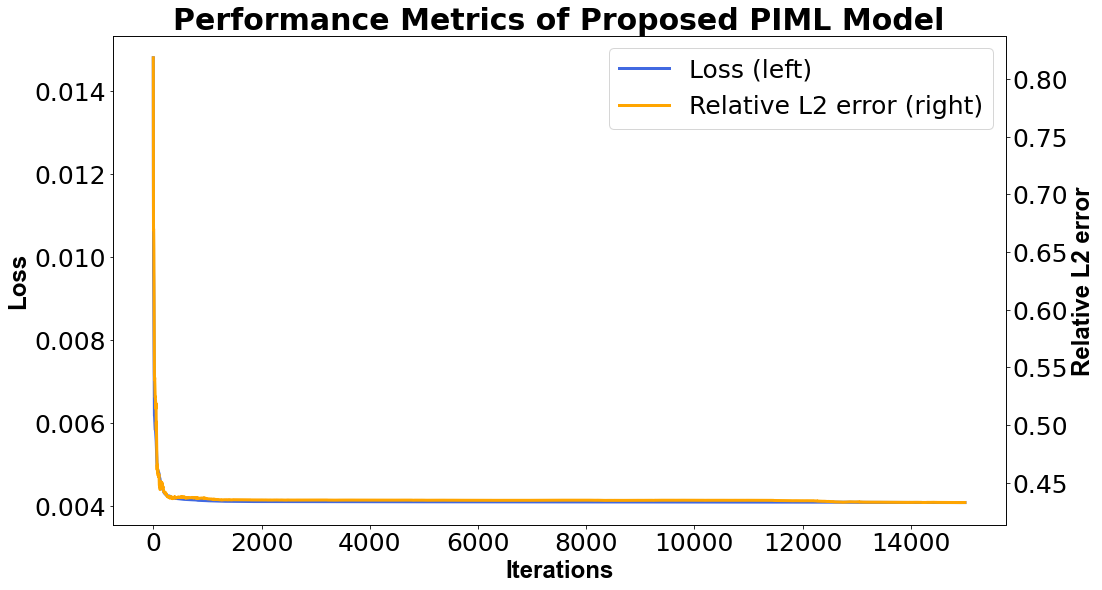

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.034949059212095096
MSE =  0.009507407985078252
RMSE =  0.09750593820418453
L2 relative error = 0.7852922987066128
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

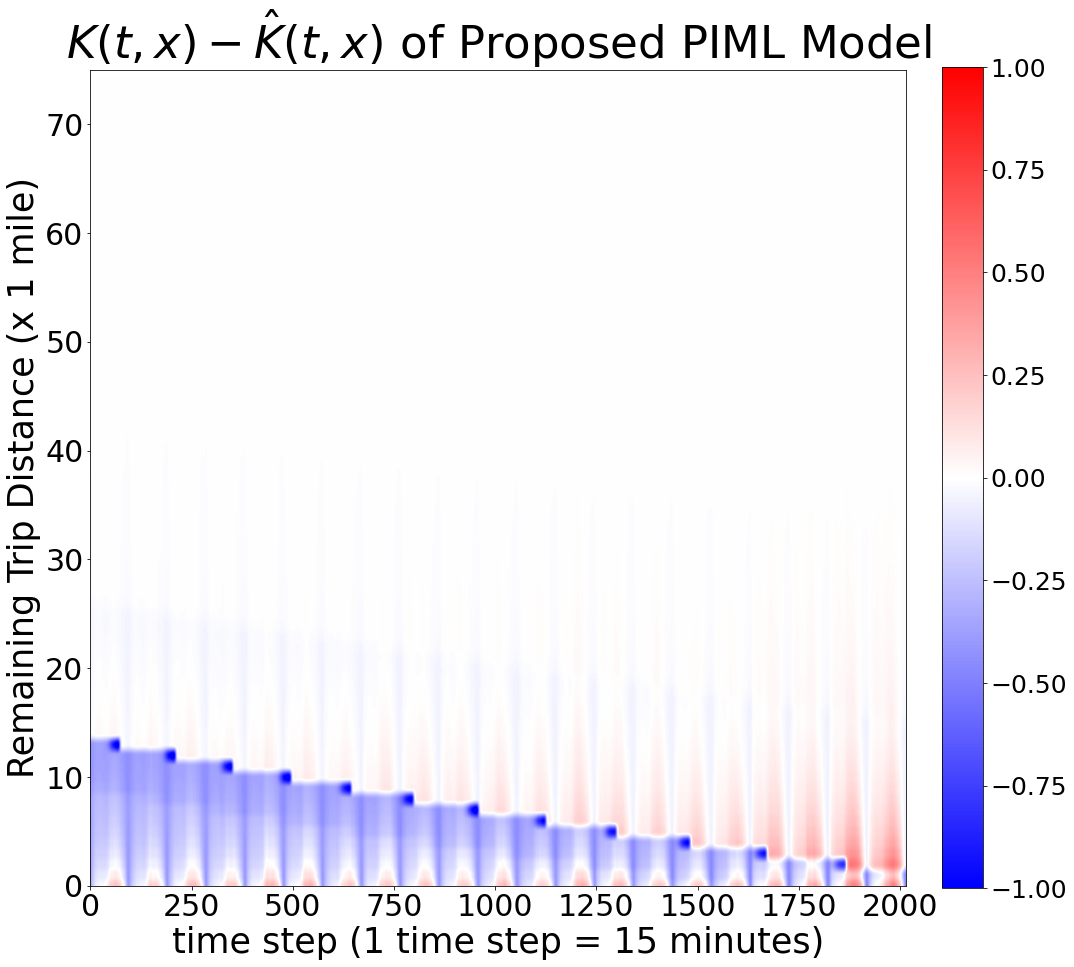

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

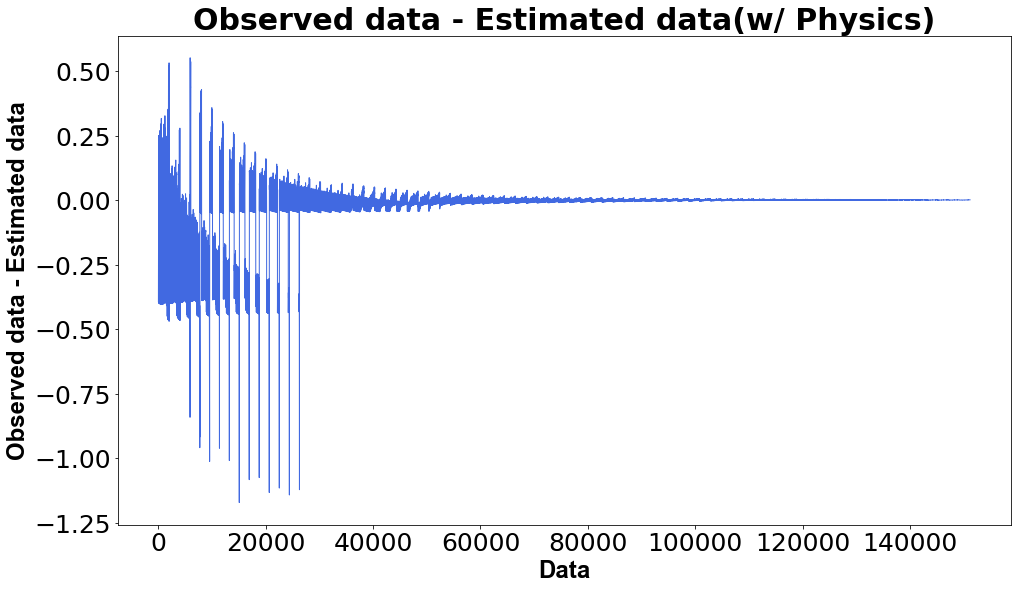

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

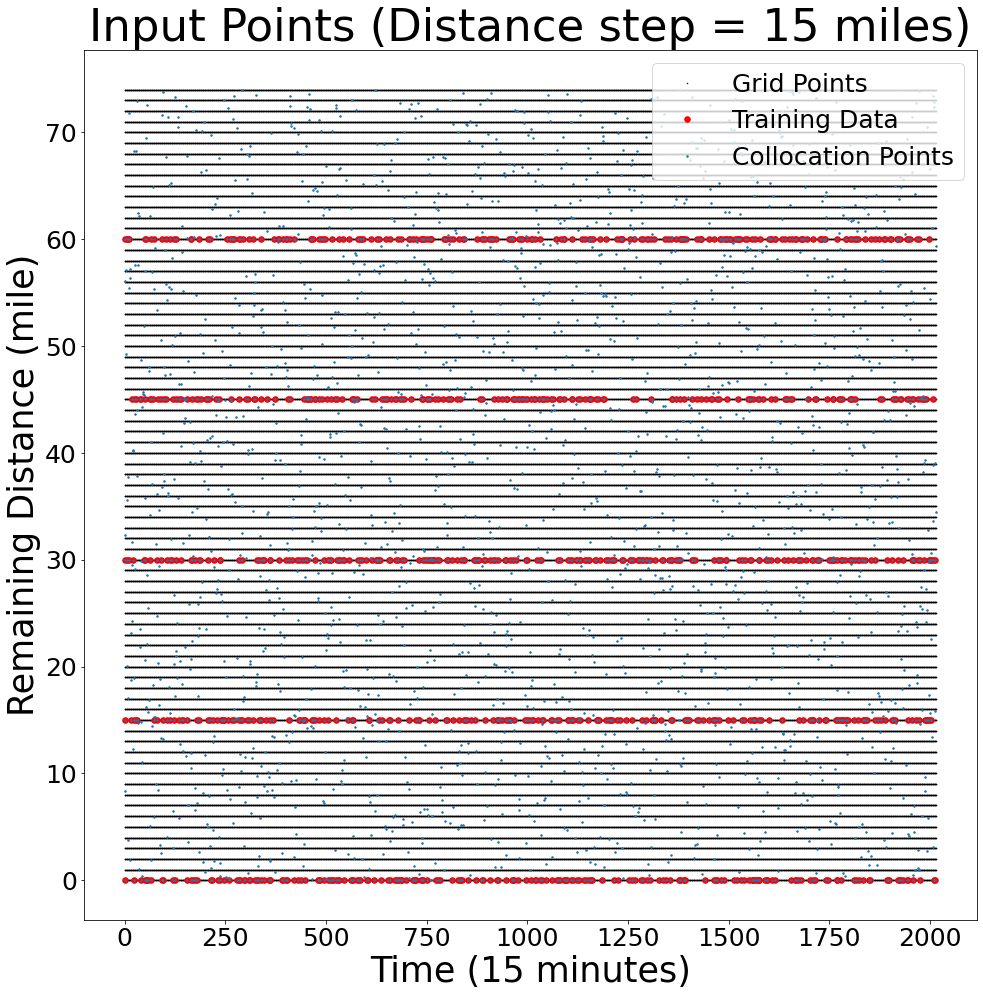

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 15 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

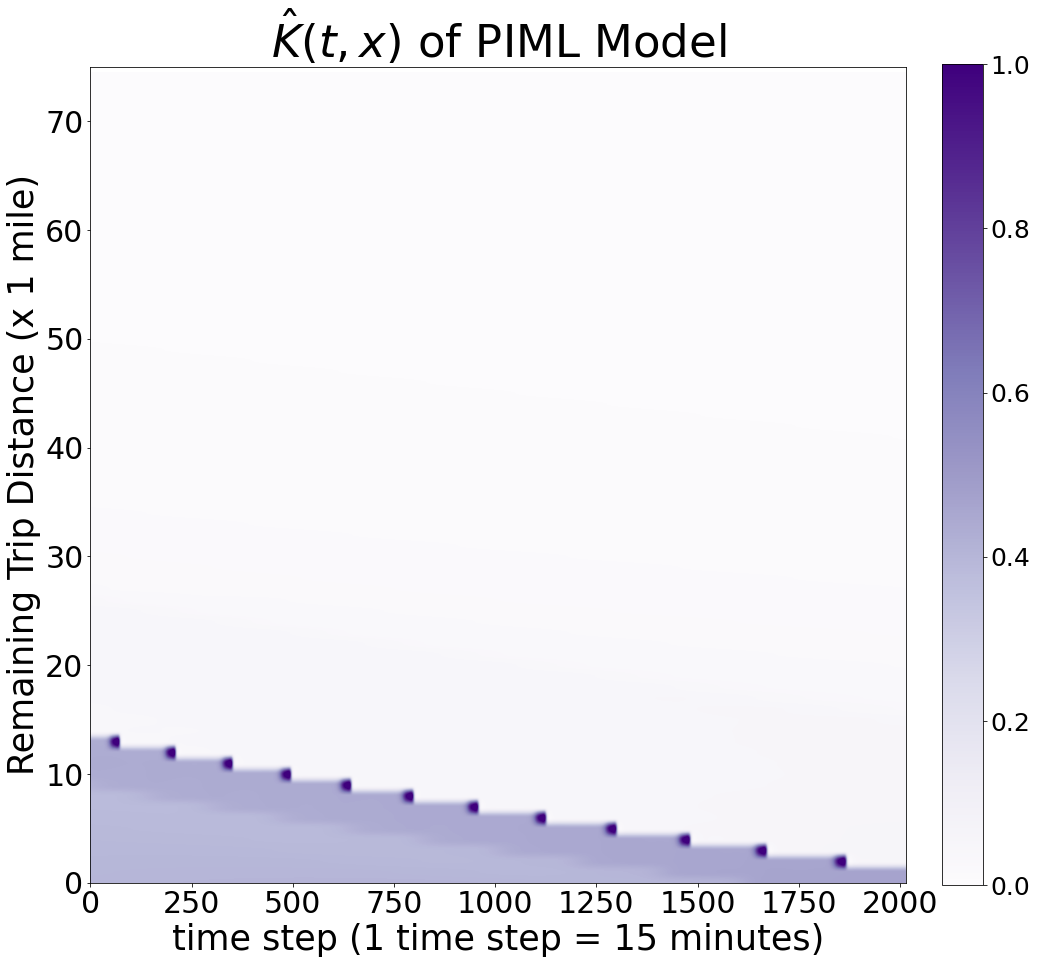

In [26]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

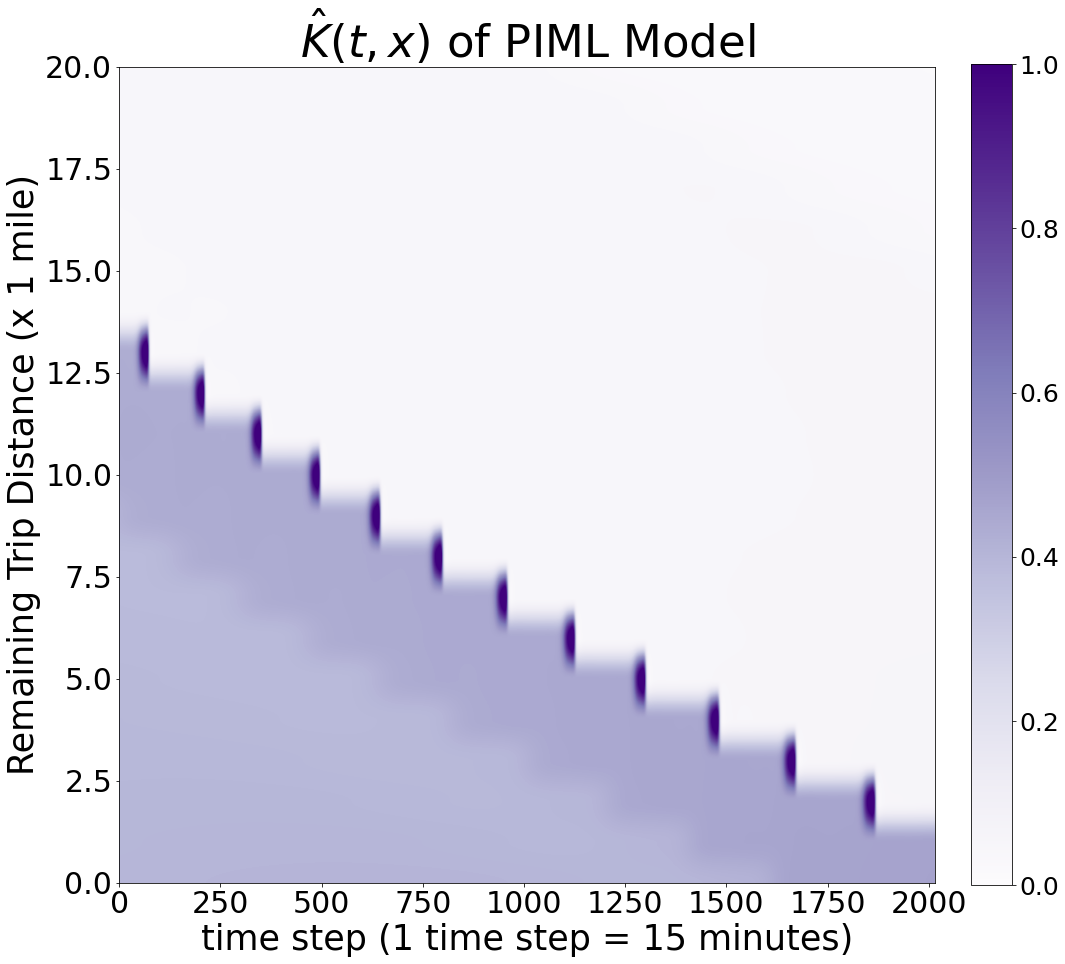

In [27]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

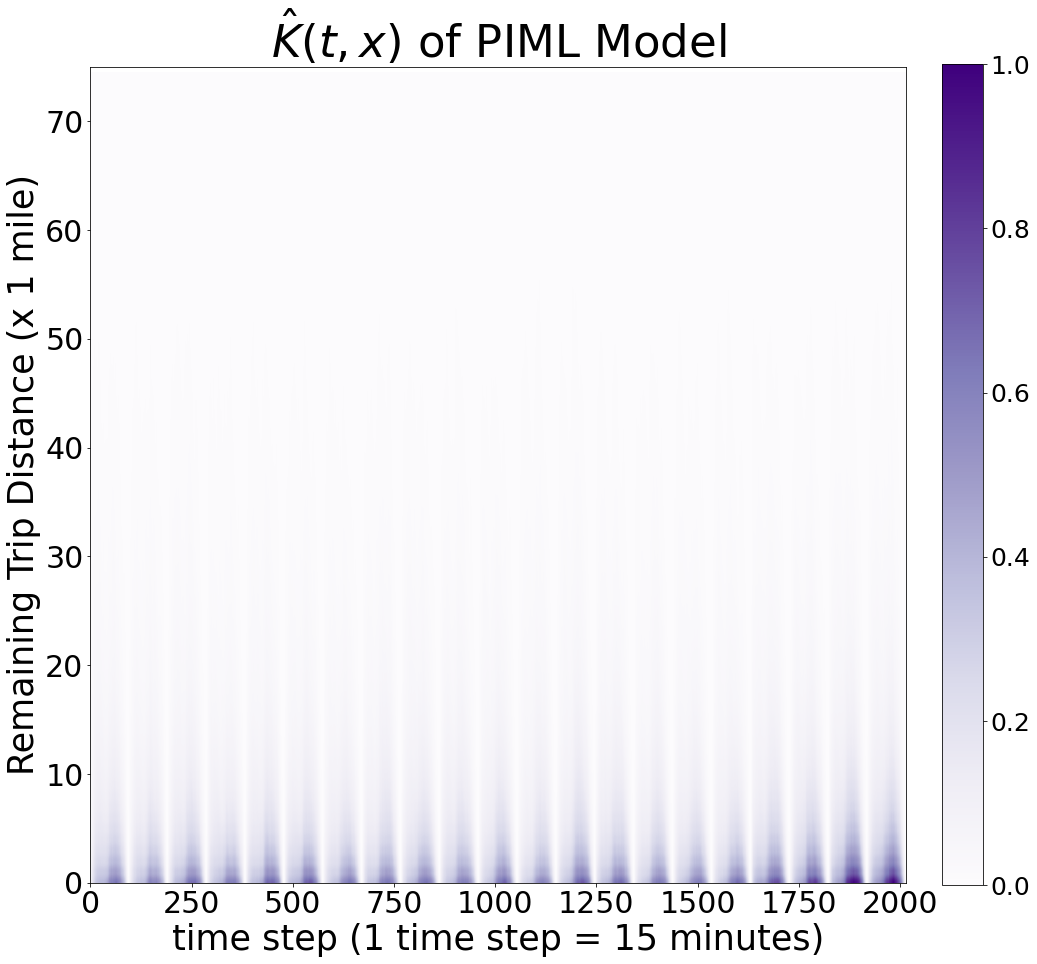

In [28]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

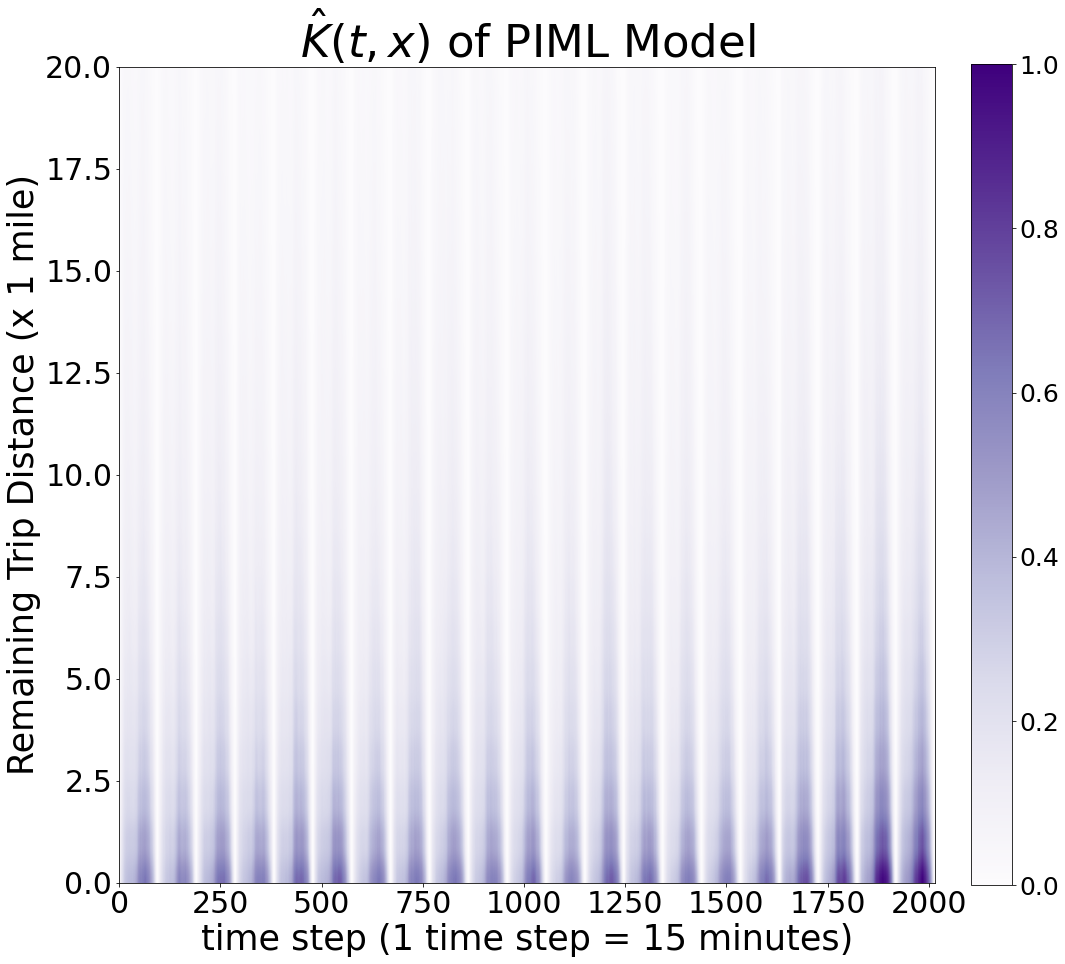

In [29]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)